In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import os
import sys
sys.path.append('/p-antipsychotics-sleep')
import numpy as np
import pickle
import argparse
import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
import textwrap

import faster2lib.eeg_tools as et
import faster2lib.summary_psd as sp
import faster2lib.summary_common as sc
import stage

from datetime import datetime
import logging
from logging import getLogger, StreamHandler, FileHandler, Formatter

import warnings
import seaborn as sns
import math
from scipy.stats import wilcoxon

In [2]:
def psd_freq_bins(sample_freq):
    """ assures frequency bins compatibe among different sampling frequencies

    Args:
        sample_freq (int): The sampling frequency

    Returns:
        np.array: An array of frequency bins
    """
    n_fft = int(256 * sample_freq/100)
    # same frequency bins given by signal.welch()
    freq_bins = 1/(n_fft/sample_freq)*np.arange(0, 129)

    return freq_bins

def get_start_indices_of_sleep_stages(stages):
    # Convert the list into a pandas Series
    stages_series = pd.Series(stages)
    # Detect the stages where the stage changes
    change_points = stages_series.ne(stages_series.shift())
    # Return a dictionary where the keys are the start indices and the values are the stages
    return {index: stage for index, stage in stages_series[change_points].items()}

def get_end_indices_of_sleep_stages(stages):
    # Convert the list into a pandas Series
    stages_series = pd.Series(stages)
    # Detect the stages where the stage changes
    change_points = stages_series.ne(stages_series.shift())
    # As we want the ending indices, we need to shift the change_points series by -1
    change_points = change_points.shift(-1).fillna(False)
    # Return a dictionary where the keys are the end indices and the values are the stages
    return {index: stage for index, stage in stages_series[change_points].items()}

def get_indices_of_stage(stage_indices, stage_name):
    # Use a dictionary comprehension to extract the indices corresponding to the specified stage
    return [index for index, stage in stage_indices.items() if stage == stage_name]

def get_nrem_spectrum(data, nrem_start_index):
    """
    Returns the frequency spectrum for the NREM start epoch.
    Parameters:
    data (2D array-like): Time-series data of the format [epoch][frequency].
    nrem_start_index (int): The index of the epoch where NREM starts.
    
    Returns:
    1D array-like: The frequency spectrum at the NREM start epoch.
    """
    return data[nrem_start_index]

def calculate_elapsed_time_df(epoch_len_sec, indices):
    # Convert the epoch length from seconds to hours
    epoch_len_hour = epoch_len_sec / 3600

    # Calculate the elapsed time for each NREM index and truncate it to an integer
    elapsed_times = [index * epoch_len_hour for index in indices]
    elapsed_times_floor = [math.floor(time) for time in elapsed_times]

    # Create a dataframe
    df = pd.DataFrame({
        'index': indices,
        'Elapsed_time': elapsed_times,
        'time_in_hour': elapsed_times_floor
    })

    return df

def calculate_avg_spectrum_per_elapsed_time(spectrum_df, elapsed_time_df):
    # Filter the spectrum dataframe to include only the rows corresponding to NREM start epochs
    stage_spectrum_df = spectrum_df.loc[elapsed_time_df['index']]

    # Add the elapsed_time_floor column to the dataframe
    stage_spectrum_df['time_in_hour'] = elapsed_time_df['time_in_hour'].values

    # Group by the elapsed_time_floor column and calculate the mean for each group
    avg_spectrum_df = stage_spectrum_df.groupby('time_in_hour').mean()

    return avg_spectrum_df

def extract_psd_each(psd_info,epoch_len_sec,sample_freq):
    freq_bin=psd_freq_bins(sample_freq)
    
    stage_call=psd_info["stage_call"]
    norm_psd=psd_info["norm"]
    start_idx=get_start_indices_of_sleep_stages(stage_call)
    nrem_start_idx= get_indices_of_stage(start_idx, 'NREM')
    rem_start_idx= get_indices_of_stage(start_idx, 'REM')
    wake_start_idx= get_indices_of_stage(start_idx, 'WAKE')
    end_idx=get_end_indices_of_sleep_stages(stage_call)
    nrem_end_idx= get_indices_of_stage(end_idx, 'NREM')
    rem_end_idx= get_indices_of_stage(end_idx, 'REM')
    wake_end_idx= get_indices_of_stage(end_idx, 'WAKE')
    
    nrem_start_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, nrem_start_idx)
    nrem_start_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 nrem_start_elapsed_time_df)   
    nrem_start_psd_df["type"]="nrem_start"
    nrem_end_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, nrem_end_idx)
    nrem_end_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 nrem_end_elapsed_time_df)
    nrem_end_psd_df["type"]="nrem_end"
    rem_start_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, rem_start_idx)
    rem_start_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 rem_start_elapsed_time_df)   
    rem_start_psd_df["type"]="rem_start"
    rem_end_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, rem_end_idx)
    rem_end_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 rem_end_elapsed_time_df)
    rem_end_psd_df["type"]="rem_end"
    
    wake_start_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, wake_start_idx)
    wake_start_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 wake_start_elapsed_time_df) 
    wake_start_psd_df["type"]="wake_start"
    wake_end_elapsed_time_df = calculate_elapsed_time_df(epoch_len_sec, wake_end_idx)
    wake_end_psd_df=calculate_avg_spectrum_per_elapsed_time(pd.DataFrame(norm_psd),
                                                                 wake_end_elapsed_time_df)
    wake_end_psd_df["type"]="wake_end"
    
    # デルタ波とシータ波の範囲のカラムを取得
    frequency_columns = [f"f@{i}" for i in freq_bin]
    delta_range=(0,4)
    theta_range=(4,12)
    delta_columns = [col for col in frequency_columns if delta_range[0] <= float(col[2:]) <= delta_range[1]]
    theta_columns = [col for col in frequency_columns if theta_range[0] <= float(col[2:]) <= theta_range[1]]
    df=pd.concat([nrem_start_psd_df,nrem_end_psd_df,rem_start_psd_df,rem_end_psd_df,wake_start_psd_df,wake_end_psd_df])
    df.columns = list(frequency_columns) + list(df.columns[129:])
    #for df in [nrem_start_psd_df,nrem_end_psd_df,rem_start_psd_df,rem_end_psd_df,wake_start_psd_df,wake_end_psd_df]:
        # 各行についてデルタ波とシータ波の平均パワーを計算
    df['delta_power'] = df[delta_columns].apply(np.mean, axis=1)
    df['theta_power'] = df[theta_columns].apply(np.mean, axis=1)
        
    return df

def extract_psd_from_psdinfo(psd_info_path,epoch_len_sec,sample_freq):
    print(psd_info_path)
    with open(psd_info_path, 'rb') as file:
        # pickle.load()関数でデータを読み込みます。
        psd_info_list = pickle.load(file)
    psd_start_n_end_df_list = []  # 修正: 各データフレームを格納するリストを用意
    
    for psd_info in psd_info_list:
        df_append = extract_psd_each(psd_info, epoch_len_sec, sample_freq).reset_index()
        df_append["exp_label"] = psd_info["exp_label"]
        df_append["mouse_group"] = psd_info["mouse_group"]
        df_append["mouse_ID"] = psd_info["mouse_id"]
        psd_start_n_end_df_list.append(df_append)  # 修正: append()の代わりにリストに追加
    
    # 修正: pd.concat()を使用してリスト内のデータフレームを結合
    psd_start_n_end_df = pd.concat(psd_start_n_end_df_list, ignore_index=True)
    psd_start_n_end_df = psd_start_n_end_df.set_index(["exp_label", "mouse_group", "mouse_ID", "type", "time_in_hour"])
    psd_start_n_end_df = psd_start_n_end_df * 100
    return psd_start_n_end_df

In [3]:
def make_df_from_summary_dic(stats_fname):
    """
    Return three DataFrames in 'column-based' form (no set_index).
    This prevents the repeated reset_index -> set_index cycle and
    avoids column/index name collisions in new Pandas versions.
    """
    print("[DEBUG] Loading:", stats_fname)
    stats = np.load(stats_fname, allow_pickle=True)[()]
    
    df_exp_info = stats["stagetime"]          # shape: (N, ?)
    data_array = stats["stagetime_profile"]   # shape: (N, 3, M)
    transition_array = stats["swtrans_profile"]  # [hourly_psw, hourly_pws]
    bout_array = stats["bout_profile"]
    
    stage_merge_list = []
    sw_transition_merge_list = []
    stage_bout_merge_list = []
    
    type_list = ["REM", "NREM", "Wake"]
    
    for i in range(df_exp_info.shape[0]):
        # 1) Sleep-Wake transition
        df_swtansition_append = pd.DataFrame({
            "exp_label": df_exp_info['Experiment label'][i],
            "mouse_group": df_exp_info['Mouse group'][i],
            "mouse_ID": df_exp_info['Mouse ID'][i],
            "hourly_psw": transition_array[i][0],
            "hourly_pws": transition_array[i][1],
            "time_in_hour": np.arange(len(transition_array[i][0]))
        })
        sw_transition_merge_list.append(df_swtansition_append)
        
        # 2) Bout count and length
        for j, stage in enumerate(type_list):
            stage_temp = "WAKE" if stage == "Wake" else stage
            bout_array_temp = bout_array[i]
            for hour in range(len(data_array[i][j])):
                filtered_bouts = bout_array_temp[
                    (bout_array_temp.stage == stage_temp) & (bout_array_temp.hour == hour)
                ]
                if filtered_bouts.empty:
                    bout_count = 0
                    mean_duration_sec = 0
                else:
                    bout_count = filtered_bouts.bout_count.iloc[0]
                    mean_duration_sec = filtered_bouts.mean_duration_sec.iloc[0]
                
                stage_bout_merge_list.append({
                    "exp_label": df_exp_info['Experiment label'][i],
                    "mouse_group": df_exp_info['Mouse group'][i],
                    "mouse_ID": df_exp_info['Mouse ID'][i],
                    "stage": stage,
                    "bout_count": bout_count,
                    "mean_duration_sec": mean_duration_sec,
                    "time_in_hour": hour
                })
        
        # 3) hourly stage
        for j, stage in enumerate(type_list):
            df_append = pd.DataFrame({
                "exp_label": df_exp_info['Experiment label'][i],
                "mouse_group": df_exp_info['Mouse group'][i],
                "mouse_ID": df_exp_info['Mouse ID'][i],
                "stage": stage,
                "min_per_hour": data_array[i][j],
                "time_in_hour": np.arange(len(data_array[i][j]))
            })
            stage_merge_list.append(df_append)
    
    # 4) 各リストを DataFrame にまとめる
    stage_merge_df = pd.concat(stage_merge_list, ignore_index=True)
    sw_transition_merge_df = pd.concat(sw_transition_merge_list, ignore_index=True)
    stage_bout_merge_df = pd.DataFrame(stage_bout_merge_list)
    
    # ※ ここではインデックスを設定しない
    # if needed: stage_merge_df.set_index(["exp_label","mouse_group","mouse_ID","stage","time_in_hour"])
    return stage_merge_df, sw_transition_merge_df, stage_bout_merge_df

def rename_group_name(merge_df, before_str, after_str):
    """
    Safely rename group name by operating on the 'mouse_group' column only.
    If 'mouse_group' is in the index, do a single reset_index().
    Avoid repeated set_index -> reset_index cycles to reduce collision errors.
    """
    # 1) index名を保存（必要なら最後に戻す or ユーザーが最後に set_indexする）
    index_name_list = list(merge_df.index.names)

    # 2) 'mouse_group' がカラムかどうかチェック
    if 'mouse_group' not in merge_df.columns:
        # インデックスにある場合は１回だけ reset_index
        merge_df = merge_df.reset_index()
        # この段階で衝突が起こる可能性がある場合は、重複カラムを削除
        if merge_df.columns.duplicated().any():
            print("[DEBUG] Duplicate columns found, removing.")
            merge_df = merge_df.loc[:, ~merge_df.columns.duplicated()]

    # 3) カラムとして存在するか再度チェック
    if 'mouse_group' in merge_df.columns:
        # 文字列置換を実施
        merge_df["mouse_group"] = merge_df["mouse_group"].str.replace(before_str, after_str)
    else:
        print("[WARN] 'mouse_group' not found as a column; skipping rename.")

    # 4) ここでは再度 set_index せず、最後にユーザー側で set_index を行うのが安全
    #    どうしても戻したい場合だけアンコメントする
    # merge_df = merge_df.set_index(index_name_list)

    return merge_df

def rename_group_name_bulk(merge_df, rename_dict):
    """
    Instead of resetting index, operate on the 'mouse_group' column directly
    if it's already a column. If it's in the index, reset once carefully.
    """
    # 1) Check if 'mouse_group' is in columns
    if "mouse_group" not in merge_df.columns:
        # If user *really* wants to rename index, do so carefully:
        merge_df = merge_df.reset_index()  # we assume minimal risk of collision
        # Then 'mouse_group' should appear as a column
    
    # 2) Now do the rename
    for before_str, after_str in rename_dict.items():
        merge_df["mouse_group"] = merge_df["mouse_group"].str.replace(before_str, after_str)
    
    # 3) (Optional) do we want to set_index again? If not needed, skip.
    # If needed, do something like:
    # merge_df = merge_df.set_index(["exp_label","mouse_group","mouse_ID","stage","time_in_hour"])
    
    return merge_df


def rename_group_of_specified_mouse(merge_df, mouse_id_list, group_str):
    """
    Update 'mouse_group' for specified mouse_id_list, avoiding repeated set_index -> reset_index cycles.
    Operate on the DataFrame as columns, not index.
    """

    # 1) インデックスに 'mouse_group' が含まれていれば、まず reset_index() してカラム化する
    if 'mouse_group' not in merge_df.columns:
        # カラムとして存在しない場合のみ reset_index
        merge_df = merge_df.reset_index()
        # 重複カラムが発生したら削除
        if merge_df.columns.duplicated().any():
            print("[DEBUG] Found duplicated columns, removing them.")
            merge_df = merge_df.loc[:, ~merge_df.columns.duplicated()]

    # 2) 'mouse_ID' も同様にカラム化されているかを確認
    if 'mouse_ID' not in merge_df.columns:
        merge_df = merge_df.reset_index()
        if merge_df.columns.duplicated().any():
            print("[DEBUG] Found duplicated columns, removing them.")
            merge_df = merge_df.loc[:, ~merge_df.columns.duplicated()]

    # 3) カラムができたら、指定のマウスIDに対して group_str をセット
    if 'mouse_ID' in merge_df.columns and 'mouse_group' in merge_df.columns:
        merge_df.loc[merge_df['mouse_ID'].isin(mouse_id_list), 'mouse_group'] = group_str
    else:
        print("[WARN] 'mouse_ID' or 'mouse_group' column not found in DataFrame. Skipping rename.")

    # 4) ここでは再度 set_index せず、必要あれば呼び出し側で最終的に set_index
    return merge_df


def add_column(merge_df, col_name, col_val):
    """
    Instead of adjusting the DataFrame index, we just add a new column.
    This approach avoids repeated reset_index -> set_index cycles.
    """
    merge_df[col_name] = col_val
    return merge_df

def read_psd_ts_csv(csvpath, stage_type):
    """
    Read PSD time-series from CSV (with multi-row header), bin the data into 60-min chunks,
    and return a column-based DataFrame (no set_index) for safer downstream usage.
    """
    # 1) CSV読み込み: multi-row headerで読み込んだデータをカラム化し、indexは捨てる
    df = pd.read_csv(csvpath, header=[0, 1, 2, 3], index_col=0).reset_index(drop=True)
    
    merge_list = []
    epoch_len_sec = 8
    
    for i in range(df.shape[1]):
        # 2) データを取り出し、60分単位(bin_num=3600/epoch_len_sec)でリシェイプして平均
        array = np.array(df.iloc[:, i])
        bin_num = int(3600 / epoch_len_sec)
        answer = divmod(len(array), bin_num)
        if answer[1] != 0:
            array = array[:-answer[1]]  # bin_num で割り切れる長さに合わせる
        
        array_reshape = array.reshape(-1, bin_num)  # 60 min (3600 sec) bin
        binned_data = np.nanmean(array_reshape, axis=1)
        
        # 3) 情報をカラムとして保持
        #    各列名(df.columns[i])は tuple なので [0], [1], [2] で取り出す
        df_append = pd.DataFrame({
            "exp_label": df.columns[i][0],
            "mouse_group": df.columns[i][1],
            "mouse_ID": df.columns[i][2],
            "stage": stage_type,
            "norm_delta_percentage": binned_data,
            "time_in_hour": np.arange(len(binned_data))
        })
        merge_list.append(df_append)
    
    # 4) リストを一括で結合し、カラムベースのDataFrameにする
    merge_df = pd.concat(merge_list, ignore_index=True)

    # --- 修正: 関数内で set_index しない ---
    # merge_df = merge_df.set_index(["exp_label", "mouse_group", "mouse_ID", "stage", "time_in_hour"])

    return merge_df



def read_hourly_psd_ts_csv(csvpath,stage_type):
    return

def merge_hourly_psd_ts_csv(dir_path):
    """
    Read PSD hourly data from CSV, fill NaNs by group, compute delta/theta power,
    and return a column-based DataFrame (no set_index inside this function).

    The caller can set_index(["exp_label","mouse_group","mouse_ID","stage","time_in_hour"])
    if needed, after this function returns.
    """
    # csv_fname を指定
    csv_fname = "PSD_raw_hourly_allday_percentage-profile.csv"

    # freq_bins: PSD周波数カラム名を生成
    freq_bins = sp.psd_freq_bins(sample_freq=128)
    frequency_columns = [f"f@{i}" for i in freq_bins]

    # デルタ/シータ波周波数レンジ
    delta_range = (1, 4)
    theta_range = (4, 12)

    delta_columns = [col for col in frequency_columns if delta_range[0] <= float(col[2:]) <= delta_range[1]]
    theta_columns = [col for col in frequency_columns if theta_range[0] <= float(col[2:]) <= theta_range[1]]

    # CSV読み込み & カラム名の統一
    df = pd.read_csv(os.path.join(dir_path, csv_fname)).rename(
        columns={
            "Experiment label": "exp_label",
            "Mouse group": "mouse_group",
            "Mouse ID": "mouse_ID",
            "Stage": "stage",
            "hour": "time_in_hour"
        }
    )

    # NaNを前後から補完：同一(mouse_ID, stage)グループごとに処理
    for column in frequency_columns:
        df[column] = (
            df.groupby(['mouse_ID', 'stage'])[column]
              .transform(lambda group: group.ffill().bfill().fillna(group.mean()))
        )

    # デルタ波 & シータ波の平均パワーを列として追加
    df['delta_power'] = df[delta_columns].mean(axis=1)
    df['theta_power'] = df[theta_columns].mean(axis=1)

    # 関数内ではインデックスを設定しない
    # df = df.set_index(["exp_label","mouse_group","mouse_ID","stage","time_in_hour"])

    return df


def merge_psd_ts_csv(dir):
    psd_norm_csv_list = [
        "power-timeseries_norm_delta_percentage_NREM.csv",
        "power-timeseries_norm_delta_percentage_Wake.csv",
        "power-timeseries_norm_delta_percentage.csv"
    ]
    stage_type_list = ["NREM", "Wake", "Total"]
    merge_list = []  # 修正: 各データフレームを格納するリストを用意
    
    for i, csv in enumerate(psd_norm_csv_list):
        df_append = read_psd_ts_csv(os.path.join(dir, csv), stage_type_list[i])
        merge_list.append(df_append)  # 修正: リストに追加
    
    # 修正: pd.concat()でリスト内のデータフレームを結合
    merge_df = pd.concat(merge_list, ignore_index=False)  # インデックスを保持する場合は ignore_index=False
    return merge_df

def meta_merge_psd_csv(analyzed_dir_list, subdir_vehicle, subdir_rapalog):
    psd_ts_list = []  # PSD timeseries データフレームを格納するリスト
    psd_profile_list = []  # PSD profile データフレームを格納するリスト

    for dir in analyzed_dir_list:
        # Vehicle データの処理
        df_append_vehicle = merge_hourly_psd_ts_csv(os.path.join(dir, subdir_vehicle, "PSD_raw"))
        df_append_vehicle = add_column(df_append_vehicle, "drug", "vehicle")
        psd_ts_list.append(df_append_vehicle)  # リストに追加

        # Rapalog データの処理
        df_append_rapalog = merge_hourly_psd_ts_csv(os.path.join(dir, subdir_rapalog, "PSD_raw"))
        df_append_rapalog = add_column(df_append_rapalog, "drug", "rapalog")
        psd_ts_list.append(df_append_rapalog)  # リストに追加

        # Profile データの処理
        csv_fname = "PSD_norm_allday_percentage-profile.csv"
        df_profile_append_vehicle = read_psd_profile_csv(os.path.join(dir, subdir_vehicle, "PSD_norm", csv_fname))
        df_profile_append_vehicle = add_column(df_profile_append_vehicle, "drug", "vehicle")
        psd_profile_list.append(df_profile_append_vehicle)  # リストに追加

        df_profile_append_rapalog = read_psd_profile_csv(os.path.join(dir, subdir_rapalog, "PSD_norm", csv_fname))
        df_profile_append_rapalog = add_column(df_profile_append_rapalog, "drug", "rapalog")
        psd_profile_list.append(df_profile_append_rapalog)  # リストに追加

    # リスト内のデータフレームを結合
    merge_psd_ts_df = pd.concat(psd_ts_list, ignore_index=False)  # 元のインデックスを保持
    merge_psd_profile_df = pd.concat(psd_profile_list, ignore_index=False)  # 元のインデックスを保持

    return merge_psd_ts_df, merge_psd_profile_df

def read_psd_profile_csv(csvpath):
    """
    Reads PSD profile data from a CSV file, processes it, and returns a DataFrame.
    The function does not set an index internally; the caller can set the index if needed.
    """
    # CSVを読み込む
    df = pd.read_csv(csvpath)

    # 必要なリストを準備
    exp_label_list = df.iloc[:, 0].unique()
    group_list = df.iloc[:, 1].unique()
    mouse_list = df.iloc[:, 2].unique()
    stage_list = df.iloc[:, 4].unique()
    freq_list = [float(s[2:]) for s in df.columns if s.startswith("f")]

    merge_list = []  # 個別データフレームを格納するリスト

    # ループでデータを抽出
    for l in exp_label_list:
        for g in group_list:
            for m in mouse_list:
                for s in stage_list:
                    # 条件に一致する行を抽出
                    filtered_df = df[
                        (df["Experiment label"] == l) &
                        (df["Mouse group"] == g) &
                        (df["Mouse ID"] == m) &
                        (df["Stage"] == s)
                    ]
                    if not filtered_df.empty:
                        try:
                            # データを整形してリストに追加
                            df_append = pd.DataFrame({
                                "exp_label": l,
                                "mouse_group": g,
                                "mouse_ID": m,
                                "stage": s,
                                "normalized_power": filtered_df.iloc[0, 6:].values,
                                "frequency": freq_list
                            })
                            merge_list.append(df_append)
                        except Exception as e:
                            print(f"[DEBUG] Error processing entry: {l}, {g}, {m}, {s}")
                            print(f"[DEBUG] Error details: {e}")
                            continue

    # 全データフレームを結合
    merge_df = pd.concat(merge_list, ignore_index=True)

    # 関数内ではインデックスを設定しない
    # merge_df = merge_df.set_index(["exp_label", "mouse_group", "mouse_ID", "stage", "frequency"])

    return merge_df


def process_stats_path_list(analyzed_dir_list,vehicle_path,rapalog_path):
    stats_list_vehicle=[]
    stats_list_rapalog=[]
    #vehicle_path="vehicle_60h/stagetime_stats.npy"
    #rapalog_path="rapalog_60h/stagetime_stats.npy"
    #vehicle_path="vehicle_84h_before_24h_after_60h/stagetime_stats.npy"
    #rapalog_path="rapalog_84h_before_24h_after_60h/stagetime_stats.npy"
    for dir in analyzed_dir_list:
        stats_list_vehicle.append(os.path.join(dir,vehicle_path))
        stats_list_rapalog.append(os.path.join(dir,rapalog_path))
    return stats_list_vehicle,stats_list_rapalog

def process_psd_info_path_list(analyzed_dir_list):
    psd_info_list_vehicle=[]
    psd_info_list_rapalog=[]
    vehicle_path="vehicle_24h_before6h/psd_info_list.pkl"
    rapalog_path="rapalog_24h_before6h/psd_info_list.pkl"
    #vehicle_path="vehicle_84h_before_24h_after_60h/stagetime_stats.npy"
    #rapalog_path="rapalog_84h_before_24h_after_60h/stagetime_stats.npy"
    for dir in analyzed_dir_list:
        psd_info_list_vehicle.append(os.path.join(dir,vehicle_path))
        psd_info_list_rapalog.append(os.path.join(dir,rapalog_path))
    return psd_info_list_vehicle,psd_info_list_rapalog

def merge_individual_df(analyzed_dir_list, vehicle_path, rapalog_path, epoch_len_sec, ample_freq):
    stats_list_vehicle, stats_list_rapalog = process_stats_path_list(analyzed_dir_list, vehicle_path, rapalog_path)
    psd_info_list_vehicle, psd_info_list_rapalog = process_psd_info_path_list(analyzed_dir_list)
    
    meta_merge_list = []  # meta_merge_df用リスト
    meta_merge_list2 = []  # meta_merge_df2用リスト
    meta_merge_list3 = []  # meta_merge_df3用リスト
    psd_start_n_end_list = []  # psd_start_n_end_df用リスト
    
    # Vehicleデータの処理
    for stats in stats_list_vehicle:
        df, df2, df3 = make_df_from_summary_dic(stats)
        df = add_column(df, "drug", "vehicle")
        meta_merge_list.append(df)
        df2 = add_column(df2, "drug", "vehicle")
        meta_merge_list2.append(df2)
        df3 = add_column(df3, "drug", "vehicle")
        meta_merge_list3.append(df3)
    
    for psd_info_list in psd_info_list_vehicle:
        df4 = extract_psd_from_psdinfo(psd_info_list, epoch_len_sec, ample_freq)
        df4 = add_column(df4, "drug", "vehicle")
        psd_start_n_end_list.append(df4)
    
    # Rapalogデータの処理
    for stats in stats_list_rapalog:
        df, df2, df3 = make_df_from_summary_dic(stats)
        df = add_column(df, "drug", "rapalog")
        meta_merge_list.append(df)
        df2 = add_column(df2, "drug", "rapalog")
        meta_merge_list2.append(df2)
        df3 = add_column(df3, "drug", "rapalog")
        meta_merge_list3.append(df3)
    
    for psd_info_list in psd_info_list_rapalog:
        df4 = extract_psd_from_psdinfo(psd_info_list, epoch_len_sec, ample_freq)
        df4 = add_column(df4, "drug", "rapalog")
        psd_start_n_end_list.append(df4)
    
    # pd.concatでリスト内のデータフレームを結合
    meta_merge_df = pd.concat(meta_merge_list, ignore_index=False)
    meta_merge_df2 = pd.concat(meta_merge_list2, ignore_index=False)
    meta_merge_df3 = pd.concat(meta_merge_list3, ignore_index=False)
    psd_start_n_end_df = pd.concat(psd_start_n_end_list, ignore_index=False)
    
    return meta_merge_df, meta_merge_df2, meta_merge_df3, psd_start_n_end_df


def exclude_mouse(meta_merge_df, exclude_mouse_list):
    """
    Exclude rows with specified mouse IDs from the DataFrame without using `set_index`.

    Parameters:
        meta_merge_df (pd.DataFrame): The input DataFrame.
        exclude_mouse_list (list): List of mouse IDs to exclude.

    Returns:
        pd.DataFrame: A DataFrame with the specified mouse IDs excluded.
    """
    # 指定されたマウスIDを除外
    filtered_df = meta_merge_df[~meta_merge_df["mouse_ID"].isin(exclude_mouse_list)].copy()

    # デバッグ情報
    print(f"[DEBUG] Original DataFrame shape: {meta_merge_df.shape}")
    print(f"[DEBUG] Filtered DataFrame shape: {filtered_df.shape}")

    return filtered_df


def plot_timeseries(ax,x_val,y_val,y_err,plot_color,label):
    ax.plot(x_val,y_val,color=plot_color,label=label)
    ax.fill_between(x_val, y_val-y_err, y_val+y_err, facecolor=plot_color, alpha=0.2)

def calculate_delta(meta_merge_df):
    """
    Calculate the delta between 'rapalog' and 'vehicle' conditions without using `set_index`.

    Parameters:
        meta_merge_df (pd.DataFrame): The input DataFrame with 'rapalog' and 'vehicle' conditions.

    Returns:
        pd.DataFrame: A DataFrame with the delta values.
    """
    # 'rapalog' 条件のデータを抽出
    delta_df = meta_merge_df[meta_merge_df['drug'] == 'rapalog'].copy()
    vehicle_df = meta_merge_df[meta_merge_df['drug'] == 'vehicle'].copy()

    # デバッグ情報
    print(f"[DEBUG] Delta DataFrame shape: {delta_df.shape}")
    print(f"[DEBUG] Vehicle DataFrame shape: {vehicle_df.shape}")

    # マージキーの決定 ('drug' を除く共通カラム)
    merge_keys = [col for col in meta_merge_df.columns if col != 'drug' and col != 'min_per_hour']
    
    # 'rapalog' と 'vehicle' をマージ
    merged_df = pd.merge(delta_df, vehicle_df, on=merge_keys, suffixes=('_rapalog', '_vehicle'))

    # デルタを計算
    merged_df["rapa-vehicle-delta_min_per_hour"] = (
        merged_df["min_per_hour_rapalog"] - merged_df["min_per_hour_vehicle"]
    )

    # 不要なカラムを削除
    result_df = merged_df.drop(columns=["drug_rapalog", "drug_vehicle", "min_per_hour_rapalog", "min_per_hour_vehicle"])

    # デバッグ情報
    print(f"[DEBUG] Result DataFrame shape: {result_df.shape}")

    return result_df


In [4]:
def merge_sleep_stage_df(analyzed_dir_list,epoch_len_sec,sample_freq):
    vehicle_path="vehicle_24h_before6h/stagetime_stats.npy"
    rapalog_path="rapalog_24h_before6h/stagetime_stats.npy"
    meta_stage_df,meta_merge_df_sw,meta_stage_bout_df,meta_psd_start_end_df=merge_individual_df(analyzed_dir_list,
                                                                          vehicle_path,rapalog_path,epoch_len_sec,sample_freq)
    return meta_stage_df,meta_merge_df_sw,meta_stage_bout_df,meta_psd_start_end_df

def merge_psd_df(analyzed_dir_list):
    subdir_vehicle="vehicle_24h_before6h"
    subdir_rapalog="rapalog_24h_before6h"
    merge_psd_ts_df,merge_psd_profile_df=meta_merge_psd_csv(analyzed_dir_list,subdir_vehicle,subdir_rapalog)
    return merge_psd_ts_df,merge_psd_profile_df

def group_analysis_each_df(df):
    """
    Perform group analysis on a DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing data to be grouped.

    Returns:
        tuple: mean, SEM, and count DataFrames.
    """
    # 必須カラムの確認
    group_keys = ["mouse_group", "drug", "stage"]
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    required_columns = group_keys + numeric_columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # インデックスを確認して必要ならリセット
    if df.index.names != [None]:
        try:
            df = df.reset_index()
        except ValueError:
            df = df.reset_index(drop=True)
    
    # グループ化
    df_grouped = df.groupby(group_keys)
    mean = df_grouped[numeric_columns].mean().reset_index()  # 平均値
    sem = df_grouped[numeric_columns].sem().reset_index()    # 標準誤差
    count = df_grouped.size().reset_index(name='count')      # サンプル数

    return mean, sem, count

def extract_mean_n_err(mean, sem, g_name, drug, sleep_stage, val_name):
    """
    Extract mean and error values for a specific group, drug, and sleep stage.

    Parameters:
        mean (pd.DataFrame): DataFrame containing mean values.
        sem (pd.DataFrame): DataFrame containing standard error values.
        g_name (str): Group name.
        drug (str): Drug name.
        sleep_stage (str): Sleep stage (e.g., "Wake").
        val_name (str): Value column name.

    Returns:
        np.ndarray, np.ndarray: Mean and error values.
    """
    # デバッグ: 入力の確認
    print(f"Extracting mean and err for group: {g_name}, drug: {drug}, stage: {sleep_stage}, value: {val_name}")
    print(f"DataFrame columns: {mean.columns}")

    # 必要なカラムが存在するか確認
    required_columns = ["mouse_group", "drug", "stage", val_name]
    for col in required_columns:
        if col not in mean.columns:
            raise KeyError(f"Column '{col}' not found in the DataFrame. Available columns: {mean.columns.tolist()}")

    # データをフィルタリング
    subset = mean[(mean["mouse_group"] == g_name) &
                  (mean["drug"] == drug) &
                  (mean["stage"] == sleep_stage)]

    # y 値を取得
    y = subset[val_name].values

    subset_sem = sem[(sem["mouse_group"] == g_name) &
                     (sem["drug"] == drug) &
                     (sem["stage"] == sleep_stage)]

    # エラー値を取得
    err = subset_sem[val_name].values

    # 配列の形状確認
    if y.shape[0] == 0 or err.shape[0] == 0:
        raise ValueError(f"No data found for the specified filter. Filter: group={g_name}, drug={drug}, stage={sleep_stage}, value={val_name}")
    print(f"Extracted y shape: {y.shape}, err shape: {err.shape}")

    return y, err



def extract_mean_n_err_for_PSD(mean, sem, g_name, drug, sleep_stage):
    """
    Extract mean and SEM values for PSD data based on group, drug, and sleep stage.

    Parameters:
        mean (pd.DataFrame): DataFrame containing mean PSD values.
        sem (pd.DataFrame): DataFrame containing SEM PSD values.
        g_name (str): Group name (e.g., "WT").
        drug (str): Drug type (e.g., "vehicle").
        sleep_stage (str): Sleep stage (e.g., "Wake").

    Returns:
        tuple: Mean and SEM values as numpy arrays.
    """
    # PSDの周波数ビン列を取得
    freq_bins = sp.psd_freq_bins(sample_freq=128)  # 必要に応じてサンプル周波数を変更
    frequency_columns = [f"f@{i}" for i in freq_bins]

    # 必須カラムの存在確認
    required_columns = ["mouse_group", "drug", "stage"] + frequency_columns
    for col in required_columns:
        if col not in mean.columns:
            raise KeyError(f"Column '{col}' not found in the DataFrame. Available columns: {mean.columns.tolist()}")

    # データフィルタリング
    subset = mean[(mean["mouse_group"] == g_name) &
                  (mean["drug"] == drug) &
                  (mean["stage"] == sleep_stage)]
    if subset.empty:
        raise ValueError(f"No data found for group '{g_name}', drug '{drug}', and sleep stage '{sleep_stage}' in mean DataFrame.")

    y = subset[frequency_columns].values.flatten()

    # SEMデータのフィルタリング
    subset_sem = sem[(sem["mouse_group"] == g_name) &
                     (sem["drug"] == drug) &
                     (sem["stage"] == sleep_stage)]
    if subset_sem.empty:
        raise ValueError(f"No data found for group '{g_name}', drug '{drug}', and sleep stage '{sleep_stage}' in SEM DataFrame.")

    err = subset_sem[frequency_columns].values.flatten()

    return y, err

def extract_sample_count(count, g_name, drug, sleep_stage):
    """
    Extract sample count from the count DataFrame.

    Parameters:
        count (pd.DataFrame): DataFrame containing sample counts.
        g_name (str): Group name (e.g., mouse group).
        drug (str): Drug name.
        sleep_stage (str): Sleep stage (e.g., "Wake").

    Returns:
        int: Sample count.
    """
    # デバッグ用にインデックス構造を確認
    print("Count DataFrame Index:", count.index)
    print("Count DataFrame Columns:", count.columns)

    # インデックスがマルチインデックスの場合
    if isinstance(count.index, pd.MultiIndex):
        try:
            sample_n = count.loc[(g_name, drug, sleep_stage), 'count']
        except KeyError:
            raise KeyError(f"Specified key not found: ({g_name}, {drug}, {sleep_stage})")
    else:
        # シングルインデックスの場合
        try:
            sample_n = count.loc[count['mouse_group'] == g_name]
            sample_n = sample_n.loc[sample_n['drug'] == drug]
            sample_n = sample_n.loc[sample_n['stage'] == sleep_stage]['count'].values[0]
        except KeyError:
            raise KeyError(f"Specified key not found in single-index DataFrame: {g_name}, {drug}, {sleep_stage}")

    return sample_n


def plot_ts_1group(mean,sem,count,g_name,sleep_stage,ax1,val_name,y_label):
    x_val=np.arange(0,24)
    dark_period=[[0,12],[24,36],[48,60]]
    light_period=[[12,24],[36,48]]
    
    y,err=extract_mean_n_err(mean,sem,g_name,"vehicle",sleep_stage,val_name)
    #sample_n=count.loc[pd.IndexSlice[g_name,"vehicle",sleep_stage,0]][0]
    drug="vehicle"
    sample_n = extract_sample_count(count, g_name, drug, sleep_stage)
    print("Sample Count:", sample_n)
    #label_str="vehicle (n=%d)"%sample_n
    label_str="vehicle"
    plot_timeseries(ax1,x_val,y,err,"k",label_str)

    y,err=extract_mean_n_err(mean,sem,g_name,"rapalog",sleep_stage,val_name)
    #sample_n=count.loc[pd.IndexSlice[g_name,"rapalog",sleep_stage,0]][0]
    drug="rapalog"
    sample_n = extract_sample_count(count, g_name, drug, sleep_stage)
    print("Sample Count:", sample_n)
    #label_str="rapalog (n=%d)"%sample_n
    label_str="rapalog"
    plot_timeseries(ax1,x_val,y,err,"r",label_str)
    
    for ax in [ax1]:
        ax.plot([0,60],[0.1,0.1],linewidth=5,color="yellow")
        ax.plot([6.5,17.5],[0.1,0.1],linewidth=5,color="k")
        #ax.plot([37,47],[0.1,0.1],linewidth=10,color="yellow")
        if val_name=="min_per_hour":
            if sleep_stage=="REM":
                ax.set_ylim([0,20])
                ax.set_yticks([0,10,20])
            else:
                ax.set_ylim([0,60])
                ax.set_yticks([0,20,40,60])
        elif val_name=="bout_count":
            if sleep_stage=="REM":
                ax.set_ylim([0,10])
                ax.set_yticks([0,5,10])
            else:
                ax.set_ylim([0,40])
                ax.set_yticks([0,20,40])
        elif val_name=="mean_duration_sec":
            if sleep_stage=="Wake":
                ax.set_ylim([0,2000])
                ax.set_yticks([0,1000,2000])
            elif sleep_stage=="NREM":
                ax.set_ylim([0,600])
                ax.set_yticks([0,300,600])
            elif sleep_stage=="REM":
                ax.set_ylim([0,100])
                ax.set_yticks([0,50,100])
        elif val_name=="norm_delta_percentage":
            ax.set_ylim([0,10])
            ax.set_yticks([0,5,10])
        elif val_name=="delta_power":
            ax.set_ylim([0,20])
            ax.set_yticks([0,10,20])
        elif val_name=="theta_power":
            ax.set_ylim([0,10])
            ax.set_yticks([0,5,10])
        elif val_name=="norm_delta_power":
            ax.set_ylim([0.8,1.2])
            ax.set_yticks([0.8,1,1.2])
        elif val_name=="norm_theta_power":
            ax.set_ylim([0.8,1.2])
            ax.set_yticks([0.8,1,1.2])
        else:
            ax.set_ylim([0,60])
            ax.set_yticks([0,20,40,60])
        #ax.set_ylabel("NREM sleep duration (min/h)")
        ax.set_ylabel(y_label)
        ax.set_xticks([0,6,12,18,24])
        ax.set_xticklabels([-6,0,6,12,18])
        ax.plot([6,6],[0,ax.get_ylim()[1]],"--",color="gray")
        ax.set_xlabel("Time after ip (h)")
        ax.set_xlim([0,24])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(fontsize=10,frameon=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

def plot_PSD_1group(mean,sem,count,g_name,sleep_stage,ax1,y_label):
    freq_bins=sp.psd_freq_bins(sample_freq=128)
    frequency_columns = [f"f@{i}" for i in freq_bins]
    x_val=freq_bins
    
    y,err=extract_mean_n_err_for_PSD(mean,sem,g_name,"vehicle",sleep_stage)
    sample_n=count.loc[pd.IndexSlice[g_name,"vehicle",sleep_stage]].max()
    #label_str="vehicle (n=%d)"%sample_n
    label_str="vehicle"
    plot_timeseries(ax1,x_val,y,err,"k",label_str)

    y,err=extract_mean_n_err_for_PSD(mean,sem,g_name,"rapalog",sleep_stage)
    sample_n=count.loc[pd.IndexSlice[g_name,"rapalog",sleep_stage]].max()
    #label_str="rapalog (n=%d)"%sample_n
    label_str="rapalog"
    plot_timeseries(ax1,x_val,y,err,"r",label_str)
    
    for ax in [ax1]:
        #ax.set_ylabel("NREM sleep duration (min/h)")
        ax.set_ylabel(y_label)
        ax.set_xticks([0,6,12,18,24,30])
        ax.set_xticklabels([0,6,12,18,24,30])
        ax.set_xlim([0,30])
        ax.set_xlabel("EEG Frequency (Hz)")
        #ax.plot([6,6],[0,60],"--",color="gray")
        if y_label=="Norm power change":
            ax.set_yticks([0.5,1,1.5])
            ax.set_yticklabels([0.5,1,1.5])
            ax.set_ylim([0.5,1.5])
        else:
            ax.set_yticks([0,5,10])
            ax.set_yticklabels([0,5,10])
            ax.set_ylim([0,10])
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(fontsize=10,frameon=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    
def plot_PSD_1group_zoom(mean,sem,count,g_name,sleep_stage,ax1,y_label):
    freq_bins=sp.psd_freq_bins(sample_freq=128)
    frequency_columns = [f"f@{i}" for i in freq_bins]
    x_val=freq_bins
    
    y,err=extract_mean_n_err_for_PSD(mean,sem,g_name,"vehicle",sleep_stage)
    sample_n=count.loc[pd.IndexSlice[g_name,"vehicle",sleep_stage]].max()
    #label_str="vehicle (n=%d)"%sample_n
    label_str="vehicle"
    plot_timeseries(ax1,x_val,y,err,"k",label_str)

    y,err=extract_mean_n_err_for_PSD(mean,sem,g_name,"rapalog",sleep_stage)
    sample_n=count.loc[pd.IndexSlice[g_name,"rapalog",sleep_stage]].max()
    #label_str="rapalog (n=%d)"%sample_n
    label_str="rapalog"
    plot_timeseries(ax1,x_val,y,err,"r",label_str)
    
    for ax in [ax1]:
        #ax.set_ylabel("NREM sleep duration (min/h)")
        ax.set_ylabel(y_label)
        ax.set_xticks([0,4,8,12])
        ax.set_xticklabels([0,4,8,12])
        ax.set_xlim([0,12])
        ax.set_xlabel("EEG Frequency (Hz)")
        #ax.plot([6,6],[0,60],"--",color="gray")
        if y_label=="Norm power change":
            #ax.set_yticks([0.6,1,1.4])
            #ax.set_yticklabels([0.6,1,1.4])
            #ax.set_ylim([0.6,1.4])
            ax.set_yticks([0.5,1,1.5])
            ax.set_yticklabels([0.5,1,1.5])
            ax.set_ylim([0.5,1.5])
        else:
            ax.set_yticks([0,5,10])
            ax.set_yticklabels([0,5,10])
            ax.set_ylim([0,10])
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.legend(fontsize=10,frameon=False)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)


def plot_bargraph(df, target_group, sleep_stage, y_value, y_label, ax, is_norm=False):
    subset = df[(df["mouse_group"] == target_group) & (df["stage"] == sleep_stage)]
    mouse_list = subset["mouse_ID"].unique()

    sns.barplot(data=subset, x="drug", y=y_value, ax=ax, palette=["r", "gray"])

    for m in mouse_list:
        data1 = subset[(subset["mouse_ID"] == m) & (subset["drug"] == "rapalog")][y_value].values
        data2 = subset[(subset["mouse_ID"] == m) & (subset["drug"] == "vehicle")][y_value].values
        ax.plot([0, 1], [data1[0], data2[0]], color="k")

    # 以下、既存の設定を維持
    for ax in [ax]:
        if y_value == "min_per_hour":
            if sleep_stage == "REM":
                ax.set_ylim([0, 10])
                ax.set_yticks([0, 5, 10])
            else:
                ax.set_ylim([0, 60])
                ax.set_yticks([0, 30, 60])
        elif y_value == "bout_count":
            if sleep_stage == "REM":
                ax.set_ylim([0, 10])
                ax.set_yticks([0, 5, 10])
            else:
                ax.set_ylim([0, 40])
                ax.set_yticks([0, 20, 40])
        elif y_value == "mean_duration_sec":
            if sleep_stage == "Wake":
                ax.set_ylim([0, 3000])
                ax.set_yticks([0, 1500, 3000])
            elif sleep_stage == "NREM":
                ax.set_ylim([0, 600])
                ax.set_yticks([0, 300, 600])
            elif sleep_stage == "REM":
                ax.set_ylim([0, 100])
                ax.set_yticks([0, 50, 100])
        elif y_value == "delta_power":
            if is_norm:
                ax.set_ylim([0.8, 1.4])
                ax.set_yticks([0.8, 1, 1.2, 1.4])
            else:
                ax.set_ylim([0, 20])
                ax.set_yticks([0, 10, 20])
        elif y_value == "theta_power":
            if is_norm:
                ax.set_ylim([0.8, 1.4])
                ax.set_yticks([0.8, 1, 1.2, 1.4])
            else:
                ax.set_ylim([0, 20])
                ax.set_yticks([0, 10, 20])
        ax.set_ylabel(y_label)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["rapalog", "vehicle"], rotation=90)
        ax.set_xlim([-0.5, 1.5])
        ax.set_xlabel("")
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


def process_group_analysis(meta_stage_df,meta_merge_df_sw,meta_stage_bout_df,merge_psd_ts_df,merge_psd_profile_df):
    meta_stage_mean,meta_stage_sem,meta_stage_count=group_analysis_each_df(meta_stage_df)
    meta_sw_mean,meta_sw_sem,meta_sw_count=group_analysis_each_df(meta_merge_df_sw)
    meta_stage_bout_mean,meta_stage_bout_sem,meta_stage_bout_count=group_analysis_each_df(meta_stage_bout_df)
    meta_psd_ts_mean,meta_psd_ts_sem,meta_psd_ts_count=group_analysis_each_df(merge_psd_ts_df)
    meta_psd_profile_mean,meta_psd_profile_sem,meta_psd_profile_count=group_analysis_each_df(merge_psd_profile_df)

In [5]:
def fill_na(df):
    df = df.sort_values(by=["mouse_ID", "stage", "time_in_hour"])
    df_filled = df.groupby(["mouse_ID", "stage"]).apply(lambda group: group.bfill().ffill())
    return df_filled

def calculate_mean_power(df, x, y):
    """
    Calculate the mean power for a specified time range.

    Parameters:
        df (pd.DataFrame): DataFrame containing time-in-hour and frequency power data.
        x (float): Start of the time range.
        y (float): End of the time range.

    Returns:
        pd.DataFrame: Grouped DataFrame with mean power values.
    """
    # インデックスをリセット
    if df.index.names != [None]:
        df = df.reset_index(drop=True)

    # 周波数カラムを動的に検出
    freq_cols = [col for col in df.columns if 'f@' in col]
    power_cols = [col for col in df.columns if 'delta_power' in col or 'theta_power' in col]
    all_power_cols = freq_cols + power_cols

    if not all_power_cols:
        raise ValueError("No valid frequency or power columns found in the DataFrame.")

    print("Detected columns for mean calculation:", all_power_cols)

    # 時間範囲でフィルタリング
    df_filtered = df[(df['time_in_hour'] >= x) & (df['time_in_hour'] <= y)]
    if df_filtered.empty:
        raise ValueError(f"No data found in the specified time range {x} to {y}.")

    print("Filtered DataFrame:\n", df_filtered.head())

    # グループ化キーを動的に決定
    if "stage" in df.columns:
        group_keys = ['exp_label', 'mouse_group', 'mouse_ID', 'stage', 'drug']
    elif "type" in df.columns:
        group_keys = ['exp_label', 'mouse_group', 'mouse_ID', 'type', 'drug']
    else:
        raise ValueError("Neither 'stage' nor 'type' column found in DataFrame.")

    # グループ化と平均値計算
    df_grouped = (
        df_filtered
        .groupby(group_keys, as_index=False)[all_power_cols]
        .mean()
    )

    print("Grouped DataFrame:\n", df_grouped.head())

    # time_in_hour の列を追加してグループ範囲の中央値を保持
    df_grouped['time_in_hour'] = (x + y) / 2

    return df_grouped



def calculate_mean_values(meta_stage_df, meta_stage_bout_df, x, y):
    # Filtering rows based on time_in_hour
    meta_stage_df_filtered = meta_stage_df[(meta_stage_df['time_in_hour'] >= x) & (meta_stage_df['time_in_hour'] <= y)]
    meta_stage_bout_df_filtered = meta_stage_bout_df[(meta_stage_bout_df['time_in_hour'] >= x) & (meta_stage_bout_df['time_in_hour'] <= y)]
    
    # Grouping by mouse_group, mouse_ID, drug, and stage, and calculating mean
    meta_stage_df_grouped = meta_stage_df_filtered.groupby(['mouse_group', 'mouse_ID', 'drug', 'stage'])['min_per_hour'].mean().reset_index()
    meta_stage_bout_df_grouped = meta_stage_bout_df_filtered.groupby(['mouse_group', 'mouse_ID', 'drug', 'stage'])[['bout_count', 'mean_duration_sec']].mean().reset_index()
    
    # Merging the two dataframes
    df_merged = pd.merge(meta_stage_df_grouped, meta_stage_bout_df_grouped, on=['mouse_group', 'mouse_ID', 'drug', 'stage'])
    return df_merged

def calculate_ratio_with_groupby(df, baseline_start, baseline_end):
    """
    Normalize data by calculating ratios with baseline values for a specified time range.

    Parameters:
        df (pd.DataFrame): DataFrame with 'time_in_hour' and numeric columns.
        baseline_start (float): Start of the baseline range for 'time_in_hour'.
        baseline_end (float): End of the baseline range for 'time_in_hour'.

    Returns:
        pd.DataFrame: DataFrame with normalized values.
    """
    # デバッグ情報
    print("Initial DataFrame Index Levels:", df.index.names)
    print("Initial DataFrame Columns:", df.columns)

    # インデックスを削除（リセットではなく単純削除）
    df = df.reset_index(drop=True)
    print("After removing index, Columns:", df.columns)

    # 数値カラムを自動検出
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    print("Detected numeric columns:", numeric_columns)

    # グループ化キー
    group_keys = ['mouse_ID', 'stage', 'exp_label', 'mouse_group', 'drug']

    # ベースラインデータを抽出
    baseline_df = df[
        (df['time_in_hour'] >= baseline_start) & (df['time_in_hour'] <= baseline_end)
    ]
    if baseline_df.empty:
        raise ValueError(f"No data found in baseline range: {baseline_start} to {baseline_end}")

    print("Baseline DataFrame:\n", baseline_df.head())

    # ベースライン値の計算
    baseline_means = (
        baseline_df.groupby(group_keys)[numeric_columns]
        .mean()
        .add_suffix('_baseline')
        .reset_index()
    )
    print("Baseline Means:\n", baseline_means.head())

    # ベースライン値を元のデータに結合
    merged_df = pd.merge(df, baseline_means, on=group_keys, how='left')

    # 正規化処理
    for col in numeric_columns:
        if col != 'time_in_hour':  # 'time_in_hour'は正規化対象外
            baseline_col = f"{col}_baseline"
            merged_df[col] = merged_df[col] / merged_df[baseline_col] * 100

    # ベースライン列を削除
    merged_df.drop(columns=[f"{col}_baseline" for col in numeric_columns if col != 'time_in_hour'], inplace=True)

    # time_in_hour の重複を防ぐために元の順序を保持
    merged_df = merged_df.sort_values(by=['mouse_ID', 'stage', 'time_in_hour']).reset_index(drop=True)

    print("Final Normalized DataFrame:\n", merged_df.head())

    return merged_df



def merge_n_plot(analyzed_dir_list, epoch_len_sec, sample_freq, exclude_mouse_list, target_group, output_dir, group_rename_dic=None):
    """
    Main function to process and visualize data with normalization and group-level analysis.

    Parameters:
        analyzed_dir_list (list): List of directories containing analysis data.
        epoch_len_sec (int): Length of epoch in seconds.
        sample_freq (int): Sampling frequency.
        exclude_mouse_list (list): List of mouse IDs to exclude.
        target_group (str): Target mouse group for analysis.
        output_dir (str): Directory to save output files.
        group_rename_dic (dict, optional): Dictionary for renaming groups.

    Returns:
        None
    """
    # --- Merge analyzed data ---
    meta_stage_df, meta_sw_trans_df, meta_stage_bout_df, meta_psd_start_end_df = merge_sleep_stage_df(analyzed_dir_list, epoch_len_sec, sample_freq)
    merge_psd_ts_df, merge_psd_profile_df = merge_psd_df(analyzed_dir_list)

    # --- Rename groups if needed ---
    if group_rename_dic:
        datasets = [meta_stage_df, meta_sw_trans_df, meta_stage_bout_df, meta_psd_start_end_df, merge_psd_ts_df, merge_psd_profile_df]
        datasets = [rename_group_name_bulk(df, group_rename_dic) for df in datasets]
        (meta_stage_df, meta_sw_trans_df, meta_stage_bout_df, meta_psd_start_end_df, merge_psd_ts_df, merge_psd_profile_df) = datasets

    # --- Exclude specific mice if needed ---
    datasets = [meta_stage_df, meta_sw_trans_df, meta_stage_bout_df, meta_psd_start_end_df, merge_psd_ts_df, merge_psd_profile_df]
    datasets = [exclude_mouse(df, exclude_mouse_list) for df in datasets]
    (meta_stage_df, meta_sw_trans_df, meta_stage_bout_df, meta_psd_start_end_df, merge_psd_ts_df, merge_psd_profile_df) = datasets

    # --- Fill missing values ---
    merge_psd_ts_df = fill_na(merge_psd_ts_df)
    #return merge_psd_ts_df
    # --- Normalize data by baseline ---
    merge_norm_psd_ts_df = calculate_ratio_with_groupby(merge_psd_ts_df, 0, 5)
    merge_norm_psd_ts_df.rename(columns={"delta_power": "norm_delta_power", "theta_power": "norm_theta_power"}, inplace=True)

    # --- Time window quantification ---
    merge_psd_ts_df_before = calculate_mean_power(merge_psd_ts_df, 6, 6)
    merge_psd_ts_df_after = calculate_mean_power(merge_psd_ts_df, 7, 7)
    print(merge_psd_ts_df)
    meta_psd_start_end_df_before = calculate_mean_power(meta_psd_start_end_df, 6, 6)
    meta_psd_start_end_df_after = calculate_mean_power(meta_psd_start_end_df, 7, 7)
    print(merge_norm_psd_ts_df)
    merge_norm_psd_ts_df_after = calculate_mean_power(merge_norm_psd_ts_df, 7, 7)
    meta_stage_n_bout_df_before = calculate_mean_values(meta_stage_df, meta_stage_bout_df, 4, 6)
    meta_stage_n_bout_df_after = calculate_mean_values(meta_stage_df, meta_stage_bout_df, 10, 21)

    # --- Save processed data ---
    datasets_to_save = {
        "meta_stage_df.csv": meta_stage_df,
        "meta_sw_trans_df.csv": meta_sw_trans_df,
        "meta_stage_bout_df.csv": meta_stage_bout_df,
        "merge_psd_ts_df.csv": merge_psd_ts_df,
        "merge_psd_profile_df.csv": merge_psd_profile_df,
        "meta_psd_start_end_df.csv": meta_psd_start_end_df,
        "meta_psd_start_end_df_before.csv": meta_psd_start_end_df_before,
        "meta_psd_start_end_df_after.csv": meta_psd_start_end_df_after,
        "meta_stage_n_bout_df_before.csv": meta_stage_n_bout_df_before,
        "meta_stage_n_bout_df_after.csv": meta_stage_n_bout_df_after,
        "merge_psd_ts_df_before.csv": merge_psd_ts_df_before,
        "merge_psd_ts_df_after.csv": merge_psd_ts_df_after,
        "merge_norm_psd_ts_df_after.csv": merge_norm_psd_ts_df_after,
    }
    for filename, df in datasets_to_save.items():
        df.to_csv(os.path.join(output_dir, filename), index=False)

    # --- Group analysis ---
    meta_stage_mean, meta_stage_sem, meta_stage_count = group_analysis_each_df(meta_stage_df)
    # デバッグ用出力
    print("Stage Mean Columns:", meta_stage_mean.columns)
    print("Stage SEM Columns:", meta_stage_sem.columns)
    print("Stage Count Columns:", meta_stage_count.columns)
    meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count = group_analysis_each_df(meta_stage_bout_df)
    meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count = group_analysis_each_df(merge_psd_ts_df)
    meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count = group_analysis_each_df(merge_norm_psd_ts_df)
    meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count = group_analysis_each_df(merge_psd_ts_df_before)
    meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count =  group_analysis_each_df(merge_psd_ts_df_after)
    meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count = group_analysis_each_df(merge_norm_psd_ts_df_after)
    # --- Plot timeseries data ---
    plot_timeseries_data(meta_stage_mean, meta_stage_sem, meta_stage_count, 
                         meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count,
                         meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count,
                         meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count,
                         meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count,
                         meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count,
                         meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count,
                         target_group, output_dir)

    # --- Plot bargraph ---
    plot_bargraphs(meta_stage_n_bout_df_after, merge_norm_psd_ts_df_after, target_group, output_dir)


def plot_timeseries_data(meta_stage_mean, meta_stage_sem, meta_stage_count, 
                         meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count,
                         meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count,
                         meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count,
                         meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count,
                         meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count,
                         meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count,
                         target_group, output_dir):
    """
    Helper function to plot timeseries data.

    Parameters:
        (various): Processed datasets for timeseries analysis.
        target_group (str): Target group to plot.
        output_dir (str): Directory to save plots.

    Returns:
        None
    """
    # フォント設定
    plt.rcParams["font.size"] = 16
    plt.rcParams['pdf.fonttype'] = 42
    # プロットの設定
    row_num = 13
    col_num = 3
    gs = gridspec.GridSpec(row_num, col_num)
    fig = plt.figure(figsize=((col_num * 3 + 1), row_num * 4))
    axes = [fig.add_subplot(gs[row, col]) for row in range(row_num) for col in range(col_num)]

    # 1行目: 各ステージの割合の時系列変化
    plot_ts_1group(meta_stage_mean, meta_stage_sem, meta_stage_count, target_group, "Wake", axes[0], "min_per_hour", "Wake duration (min/h)")
    plot_ts_1group(meta_stage_mean, meta_stage_sem, meta_stage_count, target_group, "NREM", axes[1], "min_per_hour", "NREM sleep duration (min/h)")
    plot_ts_1group(meta_stage_mean, meta_stage_sem, meta_stage_count, target_group, "REM", axes[2], "min_per_hour", "REM sleep duration (min/h)")

    # 2行目: 各ステージのブートの回数の時系列変化
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "Wake", axes[3], "bout_count", "Wake bout (/h)")
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "NREM", axes[4], "bout_count", "NREM bout (/h)")
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "REM", axes[5], "bout_count", "REM bout (/h)")

    # 3行目: 各ステージのブートの平均長さの時系列変化
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "Wake", axes[6], "mean_duration_sec", "mean Wake bout length (s)")
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "NREM", axes[7], "mean_duration_sec", "mean NREM bout length (s)")
    plot_ts_1group(meta_stage_bout_mean, meta_stage_bout_sem, meta_stage_bout_count, target_group, "REM", axes[8], "mean_duration_sec", "mean REM bout length (s)")

    # 4行目: 各ステージのデルタパワーの時系列変化
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "Wake", axes[9], "delta_power", "delta power (%)")
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "NREM", axes[10], "delta_power", "delta power (%)")
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "REM", axes[11], "delta_power", "delta power (%)")

    # 5行目: 正規化デルタパワー
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "Wake", axes[12], "norm_delta_power", "norm. delta power")
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "NREM", axes[13], "norm_delta_power", "norm. delta power")
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "REM", axes[14], "norm. delta power")

    # 6行目: シータパワー
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "Wake", axes[15], "theta_power", "theta power (%)")
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "NREM", axes[16], "theta_power", "theta power (%)")
    plot_ts_1group(meta_psd_ts_mean, meta_psd_ts_sem, meta_psd_ts_count, target_group, "REM", axes[17], "theta_power", "theta power (%)")

    # 7行目: 正規化シータパワー
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "Wake", axes[18], "norm_theta_power", "norm. theta power")
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "NREM", axes[19], "norm_theta_power", "norm. theta power")
    plot_ts_1group(meta_norm_psd_ts_mean, meta_norm_psd_ts_sem, meta_norm_psd_ts_count, target_group, "REM", axes[20], "norm. theta power")

    # 8行目: 薬剤投与前のスペクトラム
    plot_PSD_1group(meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count, target_group, "Wake", axes[21], "Normalized power (%)")
    plot_PSD_1group(meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count, target_group, "NREM", axes[22], "Normalized power (%)")
    plot_PSD_1group(meta_psd_ts_before_mean, meta_psd_ts_before_sem, meta_psd_ts_before_count, target_group, "REM", axes[23], "Normalized power (%)")

    # 9行目: 薬剤投与後のスペクトラム
    plot_PSD_1group(meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count, target_group, "Wake", axes[24], "Normalized power (%)")
    plot_PSD_1group(meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count, target_group, "NREM", axes[25], "Normalized power (%)")
    plot_PSD_1group(meta_psd_ts_after_mean, meta_psd_ts_after_sem, meta_psd_ts_after_count, target_group, "REM", axes[26], "Normalized power (%)")

    # 12行目: 正規化スペクトラム変化
    plot_PSD_1group(meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count, target_group, "Wake", axes[33], "Norm power change")
    plot_PSD_1group(meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count, target_group, "NREM", axes[34], "Norm power change")
    plot_PSD_1group(meta_norm_psd_ts_after_mean, meta_norm_psd_ts_after_sem, meta_norm_psd_ts_after_count, target_group, "REM", axes[35], "Norm power change")

    # プロット保存
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "timeseries_and_PSD_plot.pdf"))
    plt.close(fig)

def plot_bargraphs(meta_stage_n_bout_df_after, merge_norm_psd_ts_df_after, target_group, output_dir):
    """
    Function to plot bargraphs for various sleep stage and power changes.

    Parameters:
        meta_stage_n_bout_df_after (pd.DataFrame): Processed dataframe for stage and bout analysis.
        merge_norm_psd_ts_df_after (pd.DataFrame): Processed dataframe for normalized PSD timeseries.
        target_group (str): Target group for analysis.
        output_dir (str): Directory to save the bargraph plots.

    Returns:
        None
    """
    # フォント設定
    plt.rcParams["font.size"] = 16
    plt.rcParams['pdf.fonttype'] = 42
    # プロット設定
    row_num = 5
    col_num = 3
    gs = gridspec.GridSpec(row_num, col_num)
    fig = plt.figure(figsize=((col_num * 3 + 1), row_num * 4))
    axes = [fig.add_subplot(gs[row, col]) for row in range(row_num) for col in range(col_num)]

    # 1行目: 各ステージの割合の時系列変化の平均値
    df = meta_stage_n_bout_df_after
    plot_bargraph(df, target_group, sleep_stage="Wake", y_value="min_per_hour",
                  y_label="mean Wake duration (min/h)\n during 1-3h after ip", ax=axes[0])
    plot_bargraph(df, target_group, sleep_stage="NREM", y_value="min_per_hour",
                  y_label="mean NREM duration (min/h)\n during 1-3h after ip", ax=axes[1])
    plot_bargraph(df, target_group, sleep_stage="REM", y_value="min_per_hour",
                  y_label="mean REM duration (min/h)\n during 1-3h after ip", ax=axes[2])

    # 2行目: 各ステージのブート数の時系列変化の平均値
    plot_bargraph(df, target_group, sleep_stage="Wake", y_value="bout_count",
                  y_label="mean Wake bout count (/h)\n during 1-3h after ip", ax=axes[3])
    plot_bargraph(df, target_group, sleep_stage="NREM", y_value="bout_count",
                  y_label="mean NREM bout count (/h)\n during 1-3h after ip", ax=axes[4])
    plot_bargraph(df, target_group, sleep_stage="REM", y_value="bout_count",
                  y_label="mean REM bout count (/h)\n during 1-3h after ip", ax=axes[5])

    # 3行目: 各ステージのブートの長さの時系列変化の平均値
    plot_bargraph(df, target_group, sleep_stage="Wake", y_value="mean_duration_sec",
                  y_label="mean Wake bout length (s)\n during 1-3h after ip", ax=axes[6])
    plot_bargraph(df, target_group, sleep_stage="NREM", y_value="mean_duration_sec",
                  y_label="mean NREM bout length (s)\n during 1-3h after ip", ax=axes[7])
    plot_bargraph(df, target_group, sleep_stage="REM", y_value="mean_duration_sec",
                  y_label="mean REM bout length (s)\n during 1-3h after ip", ax=axes[8])

    # 4行目: 各ステージの薬剤投与後のデルタパワーの変化
    df = merge_norm_psd_ts_df_after
    plot_bargraph(df, target_group, sleep_stage="Wake", y_value="delta_power",
                  y_label="relative delta power change\n during 1h after ip", ax=axes[9], is_norm=True)
    plot_bargraph(df, target_group, sleep_stage="NREM", y_value="delta_power",
                  y_label="relative delta power change\n during 1h after ip", ax=axes[10], is_norm=True)
    plot_bargraph(df, target_group, sleep_stage="REM", y_value="delta_power",
                  y_label="relative delta power change\n during 1-3h after ip", ax=axes[11], is_norm=True)

    # 5行目: 各ステージの薬剤投与後のシータパワーの変化
    plot_bargraph(df, target_group, sleep_stage="Wake", y_value="theta_power",
                  y_label="relative theta power change\n during 1h after ip", ax=axes[12], is_norm=True)
    plot_bargraph(df, target_group, sleep_stage="NREM", y_value="theta_power",
                  y_label="relative theta power change\n during 1h after ip", ax=axes[13], is_norm=True)
    plot_bargraph(df, target_group, sleep_stage="REM", y_value="theta_power",
                  y_label="relative theta power change\n during 1-3h after ip", ax=axes[14], is_norm=True)

    # プロット表示と保存
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "bargraph.pdf"))
    plt.close(fig)
    
def wilcoxon_n_paried_t(stage_df,psd_df,bout_df,target_group,stage):
    print(stage)
    print(target_group)
    print("stage duration")
    data1=stage_df[(stage_df.mouse_group==target_group)&(stage_df.stage==stage)&(stage_df.drug=="vehicle")].min_per_hour
    data2=stage_df[(stage_df.mouse_group==target_group)&(stage_df.stage==stage)&(stage_df.drug=="rapalog")].min_per_hour
    
    # ウィルコクソンの符号順位検定
    statistic, p_value = wilcoxon(data1, data2)
    print("wilcoxon")
    print('Statistic:', statistic)
    print('p-value:', p_value)

    #from scipy.stats import ttest_rel
    #statistic, p_value = ttest_rel(data1, data2)
    #print("paired t test")
    #print('Statistic:', statistic)
    #print('p-value:', p_value)
    
    print("stage bout count")
    data1=bout_df[(bout_df.mouse_group==target_group)&(bout_df.stage==stage)&(bout_df.drug=="vehicle")].bout_count
    data2=bout_df[(bout_df.mouse_group==target_group)&(bout_df.stage==stage)&(bout_df.drug=="rapalog")].bout_count
    
    # ウィルコクソンの符号順位検定
    statistic, p_value = wilcoxon(data1, data2)
    print("wilcoxon")
    print('Statistic:', statistic)
    print('p-value:', p_value)
    
    print("stage bout length")
    data1=bout_df[(bout_df.mouse_group==target_group)&(bout_df.stage==stage)&(bout_df.drug=="vehicle")].mean_duration_sec
    data2=bout_df[(bout_df.mouse_group==target_group)&(bout_df.stage==stage)&(bout_df.drug=="rapalog")].mean_duration_sec

    # ウィルコクソンの符号順位検定
    statistic, p_value = wilcoxon(data1, data2)
    print("wilcoxon")
    print('Statistic:', statistic)
    print('p-value:', p_value)

    print("norm delta power")
    data1=psd_df[(psd_df.mouse_group==target_group)&(psd_df.stage==stage)&(psd_df.drug=="vehicle")].delta_power
    data2=psd_df[(psd_df.mouse_group==target_group)&(psd_df.stage==stage)&(psd_df.drug=="rapalog")].delta_power

    # ウィルコクソンの符号順位検定
    statistic, p_value = wilcoxon(data1, data2)
    print("wilcoxon")
    print('Statistic:', statistic)
    print('p-value:', p_value)

    return

# Analysis for sleep stage and PSD

[DEBUG] Loading: /p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/vehicle_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/vehicle_24h_before6h/psd_info_list.pkl
[DEBUG] Loading: /p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/rapalog_24h_before6h/stagetime_stats.npy


/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202/rapalog_24h_before6h/psd_info_list.pkl


/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_6002/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_dow

[DEBUG] Original DataFrame shape: (576, 7)
[DEBUG] Filtered DataFrame shape: (576, 7)
[DEBUG] Original DataFrame shape: (192, 7)
[DEBUG] Filtered DataFrame shape: (192, 7)
[DEBUG] Original DataFrame shape: (576, 8)
[DEBUG] Filtered DataFrame shape: (576, 8)
[DEBUG] Original DataFrame shape: (1012, 137)
[DEBUG] Filtered DataFrame shape: (1012, 137)
[DEBUG] Original DataFrame shape: (576, 139)
[DEBUG] Filtered DataFrame shape: (576, 139)
[DEBUG] Original DataFrame shape: (3096, 7)
[DEBUG] Filtered DataFrame shape: (3096, 7)
Initial DataFrame Index Levels: ['mouse_ID', 'stage', None]
Initial DataFrame Columns: Index(['exp_label', 'mouse_group', 'mouse_ID', 'Device label', 'stage',
       'epoch #', 'time_in_hour', 'f@0.0', 'f@0.39143730886850153',
       'f@0.7828746177370031',
       ...
       'f@47.75535168195719', 'f@48.14678899082569', 'f@48.53822629969419',
       'f@48.92966360856269', 'f@49.321100917431195', 'f@49.71253822629969',
       'f@50.103975535168196', 'delta_power', 'the

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

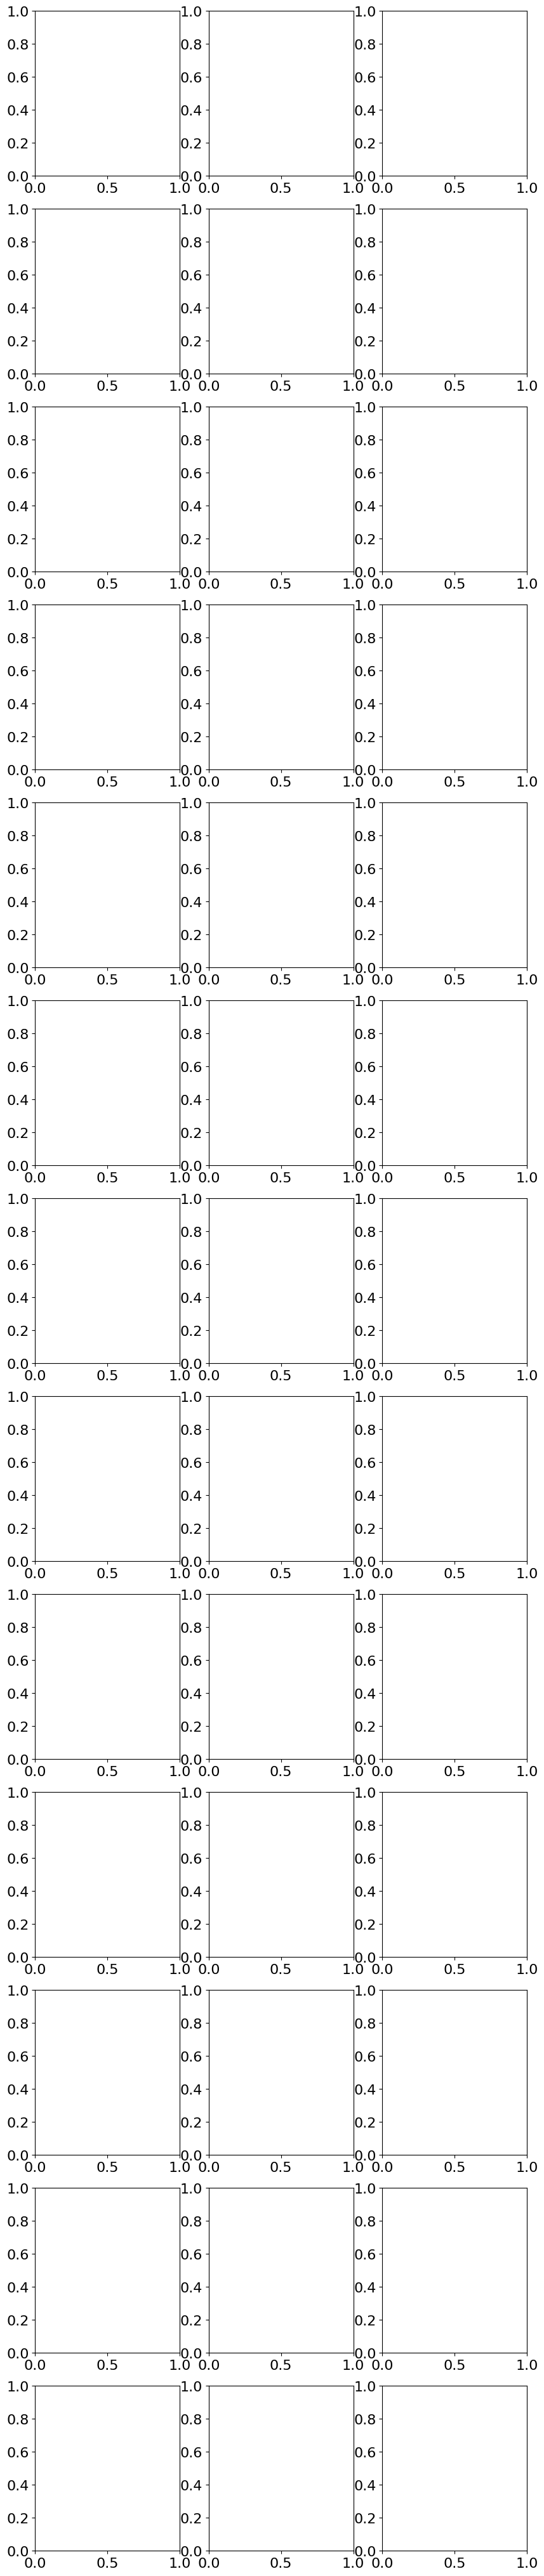

In [6]:
analyzed_dir_list=["/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202"]

#"/temp/analyzed/prj11/20231230_2" is omitted by abnormal PSD shape

rename_dict = {
    "PFC-ex-enlarge-HP-hM4Di": "PFC-ex-enlarge",
    "uniPFC-ex-enlarge": "PFC-ex-enlarge",
    "biPFC-ex-enlarge": "PFC-ex-enlarge",
    "noAAV": "PFC-ex-GFPctrl"
    }

exclude_mouse_list=[]
target_group="WT"
output_dir="/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP"
os.makedirs(output_dir,exist_ok=True)
epoch_len_sec=8
sample_freq=128
merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)
#test=merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)

[DEBUG] Loading: /p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric/vehicle_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric/vehicle_24h_before6h/psd_info_list.pkl


/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

[DEBUG] Loading: /p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric/rapalog_24h_before6h/stagetime_stats.npy
/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric/rapalog_24h_before6h/psd_info_list.pkl


/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  change_points = change_points.shift(-1).fillna(False)
/tmp/ipykernel_22218/3679556294.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

[DEBUG] Original DataFrame shape: (576, 7)
[DEBUG] Filtered DataFrame shape: (576, 7)
[DEBUG] Original DataFrame shape: (192, 7)
[DEBUG] Filtered DataFrame shape: (192, 7)
[DEBUG] Original DataFrame shape: (576, 8)
[DEBUG] Filtered DataFrame shape: (576, 8)
[DEBUG] Original DataFrame shape: (970, 137)
[DEBUG] Filtered DataFrame shape: (970, 137)
[DEBUG] Original DataFrame shape: (576, 139)
[DEBUG] Filtered DataFrame shape: (576, 139)
[DEBUG] Original DataFrame shape: (3096, 7)
[DEBUG] Filtered DataFrame shape: (3096, 7)
Initial DataFrame Index Levels: ['mouse_ID', 'stage', None]
Initial DataFrame Columns: Index(['exp_label', 'mouse_group', 'mouse_ID', 'Device label', 'stage',
       'epoch #', 'time_in_hour', 'f@0.0', 'f@0.39143730886850153',
       'f@0.7828746177370031',
       ...
       'f@47.75535168195719', 'f@48.14678899082569', 'f@48.53822629969419',
       'f@48.92966360856269', 'f@49.321100917431195', 'f@49.71253822629969',
       'f@50.103975535168196', 'delta_power', 'theta

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

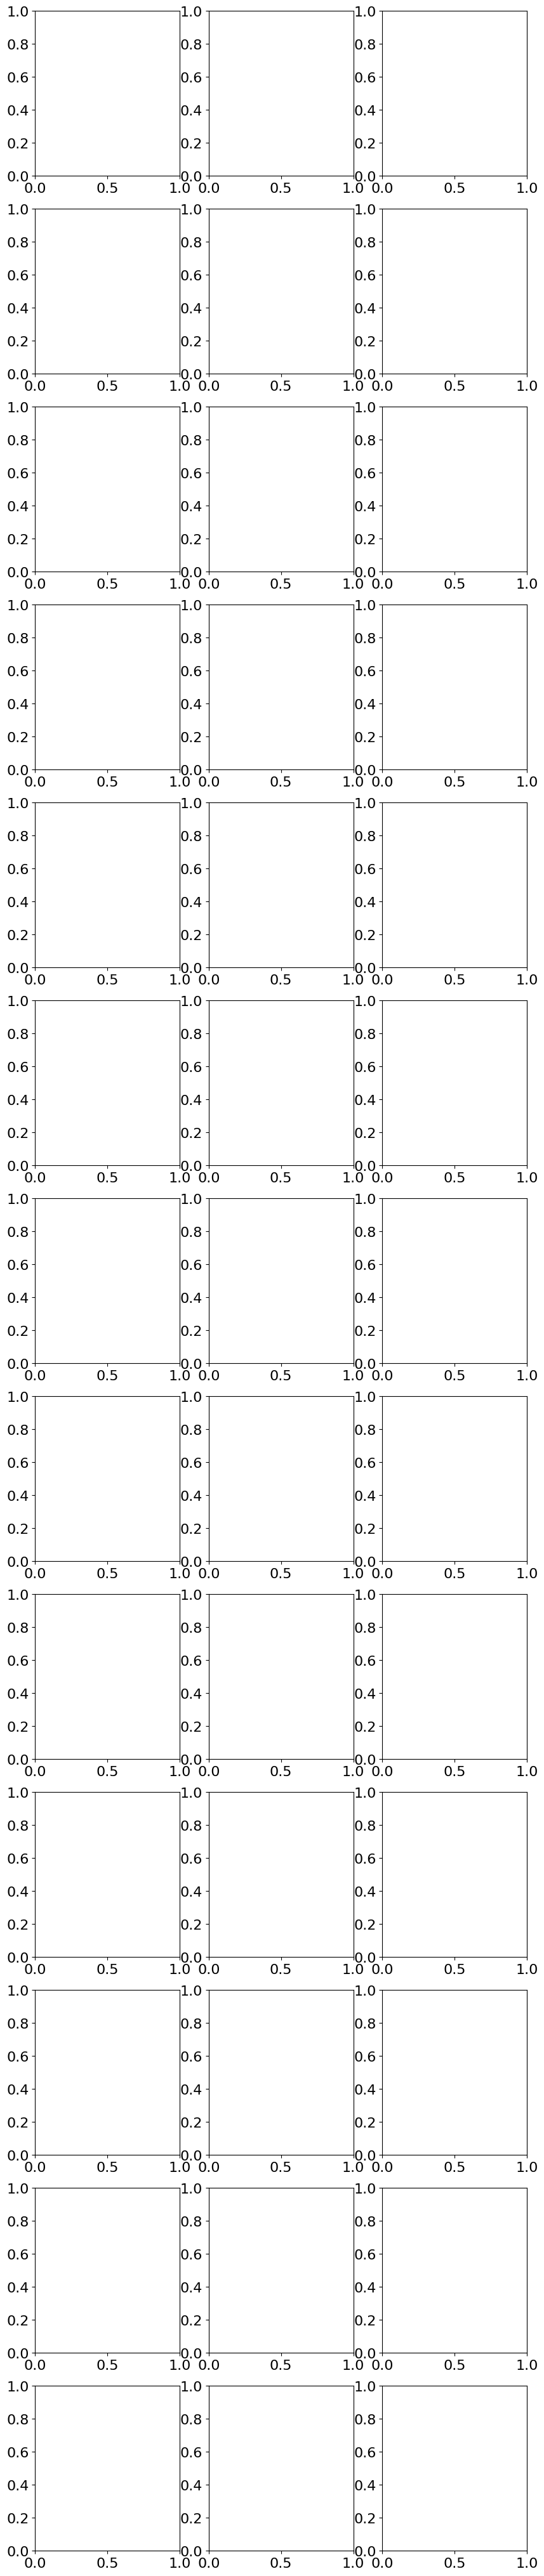

In [7]:
analyzed_dir_list=["/p-antipsychotics-sleep/analyzed/prjCZP-9/20241202_muric"]

#"/temp/analyzed/prj11/20231230_2" is omitted by abnormal PSD shape

rename_dict = {
    "PFC-ex-enlarge-HP-hM4Di": "PFC-ex-enlarge",
    "uniPFC-ex-enlarge": "PFC-ex-enlarge",
    "biPFC-ex-enlarge": "PFC-ex-enlarge",
    "noAAV": "PFC-ex-GFPctrl"
    }

exclude_mouse_list=[]
target_group="WT"
output_dir="/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric"
os.makedirs(output_dir,exist_ok=True)
epoch_len_sec=8
sample_freq=128
merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)
#test=merge_n_plot(analyzed_dir_list,epoch_len_sec,sample_freq,exclude_mouse_list,target_group,output_dir,group_rename_dic=rename_dict)

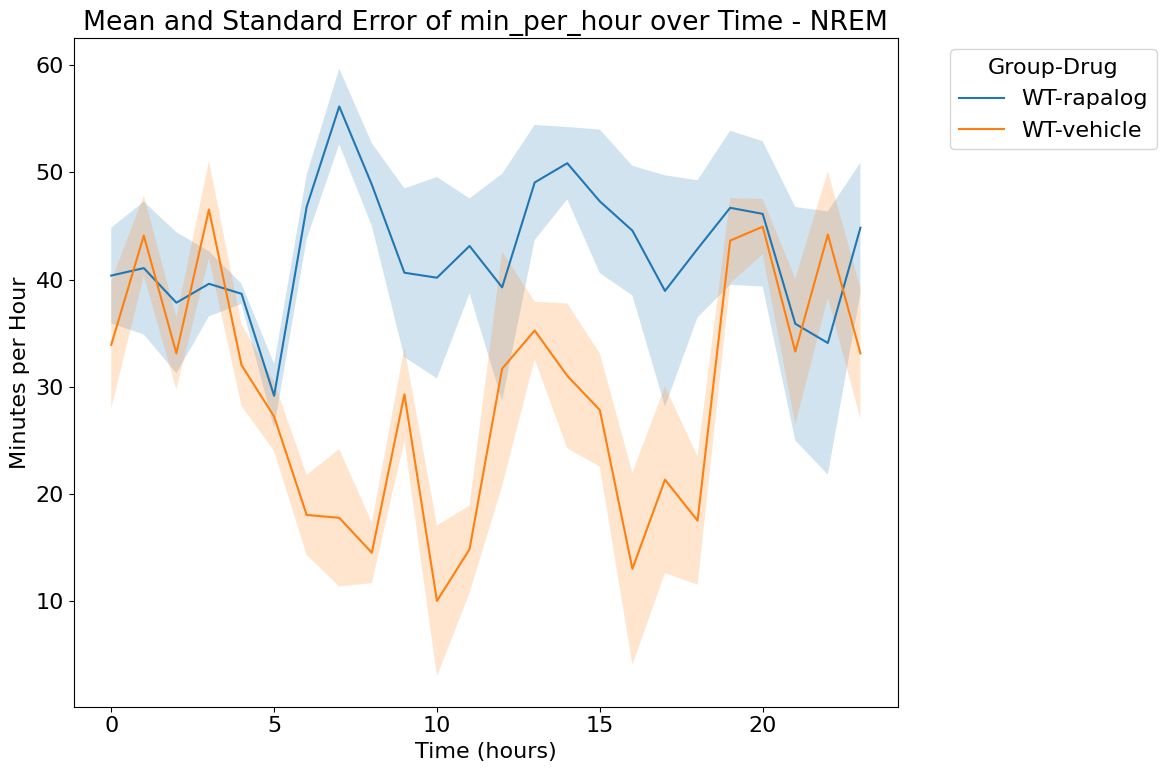

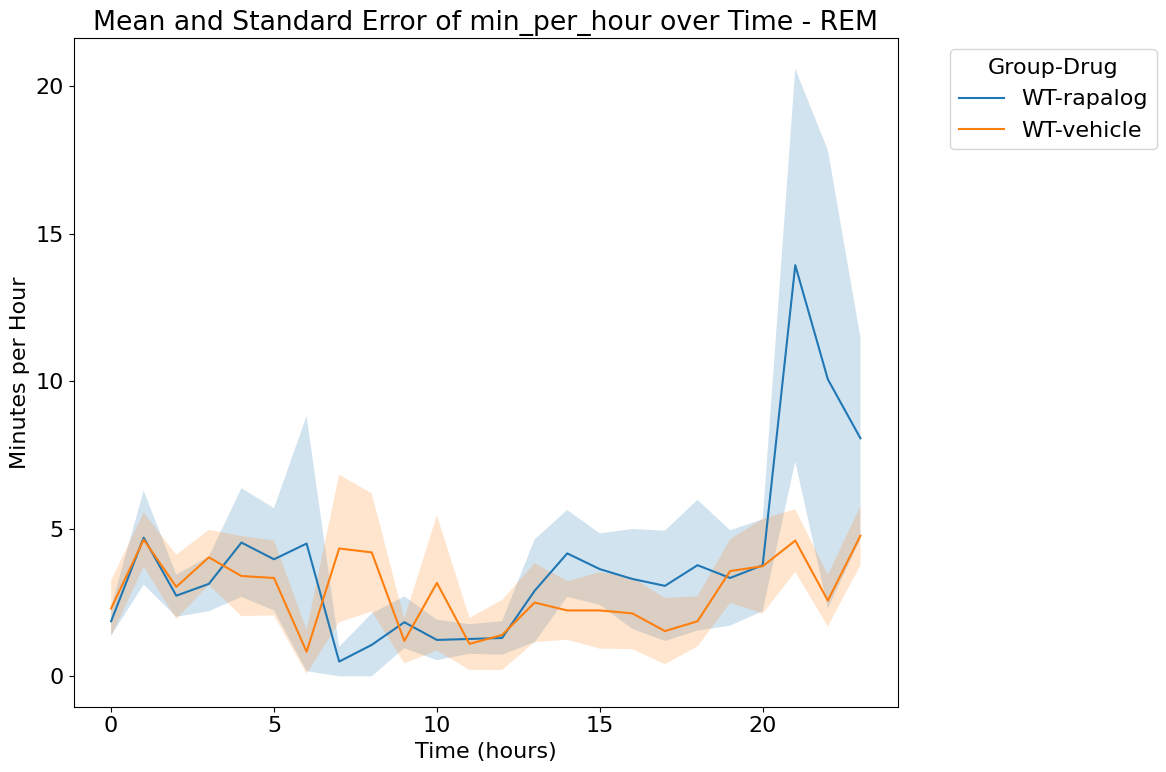

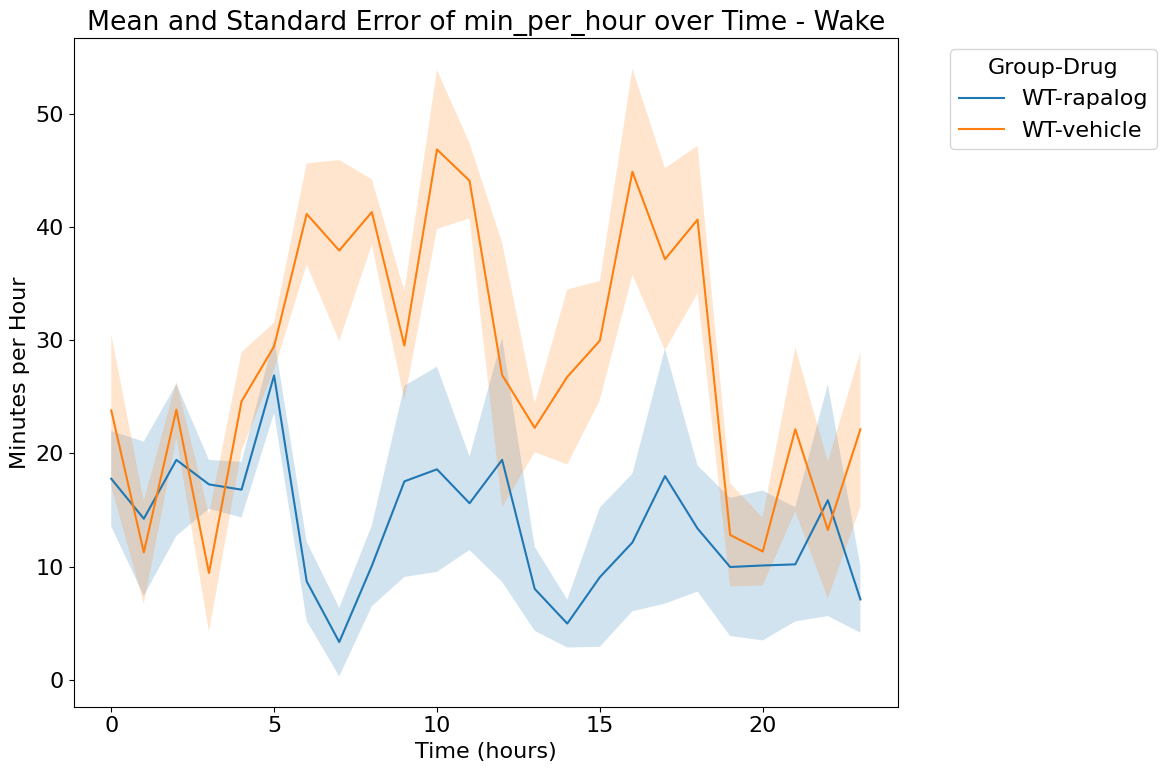

In [7]:
# Load the data
data = pd.read_csv('/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/meta_stage_df.csv')

# Group by the relevant columns and calculate mean and standard error
summary = data.groupby(['mouse_group', 'stage', 'time_in_hour', 'drug'])['min_per_hour']\
    .agg(mean='mean', sem='sem').reset_index()

# Plotting
stages = summary['stage'].unique()

for stage in stages:
    stage_data = summary[summary['stage'] == stage]
    plt.figure(figsize=(12, 8))

    for (mouse_group, drug), group_data in stage_data.groupby(['mouse_group', 'drug']):
        x = group_data['time_in_hour']
        y = group_data['mean']
        yerr = group_data['sem']

        plt.plot(x, y, label=f'{mouse_group}-{drug}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    # Customizing the plot
    plt.xlabel('Time (hours)')
    plt.ylabel('Minutes per Hour')
    plt.title(f'Mean and Standard Error of min_per_hour over Time - {stage}')
    plt.legend(title='Group-Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()


In [12]:
import pandas as pd
meta_stage_df=pd.read_csv("/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/meta_stage_df.csv")

In [13]:
meta_stage_df

,exp_label,mouse_group,mouse_ID,stage,min_per_hour,time_in_hour,drug
0,EEG_p-iino-1-1,WT,YI033,REM,3.866667,0,vehicle
1,EEG_p-iino-1-1,WT,YI033,REM,6.800000,1,vehicle
2,EEG_p-iino-1-1,WT,YI033,REM,4.666667,2,vehicle
3,EEG_p-iino-1-1,WT,YI033,REM,4.800000,3,vehicle
4,EEG_p-iino-1-1,WT,YI033,REM,5.466667,4,vehicle
...,...,...,...,...,...,...,...
571,EEG_p-iino-1-1,WT,YI036,Wake,12.666667,19,rapalog
572,EEG_p-iino-1-1,WT,YI036,Wake,10.133333,20,rapalog
573,EEG_p-iino-1-1,WT,YI036,Wake,23.733333,21,rapalog
574,EEG_p-iino-1-1,WT,YI036,Wake,3.200000,22,rapalog


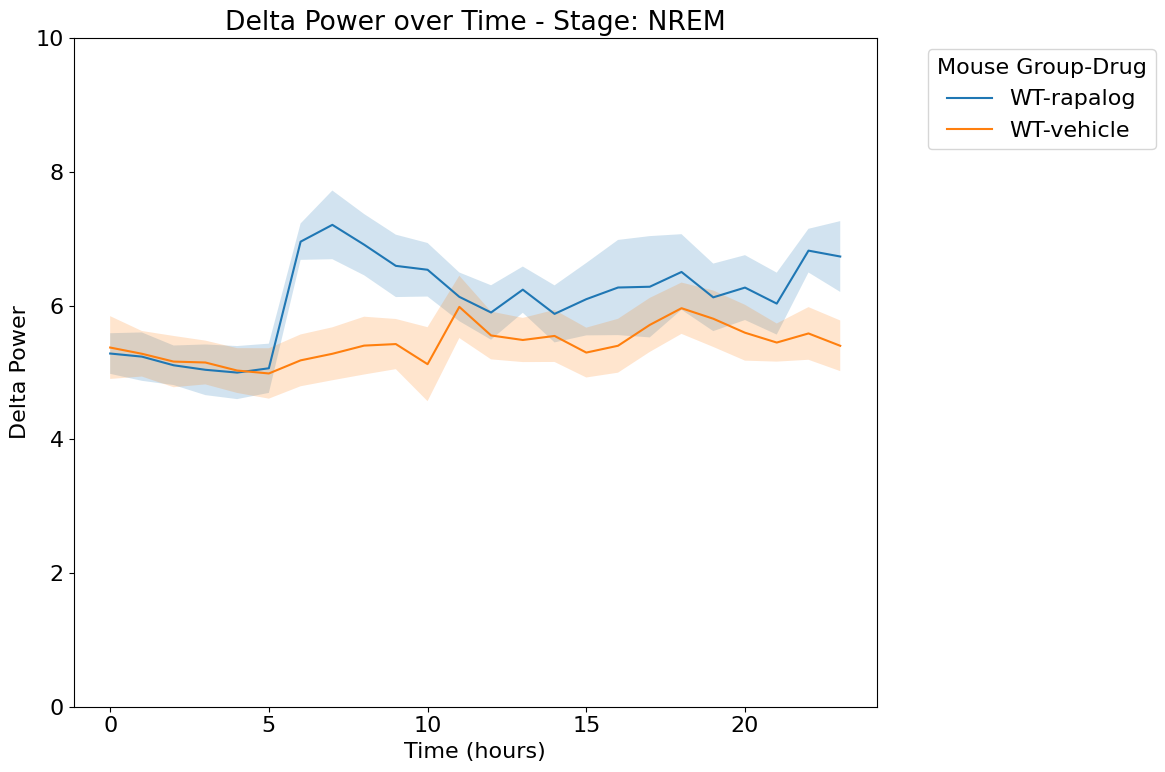

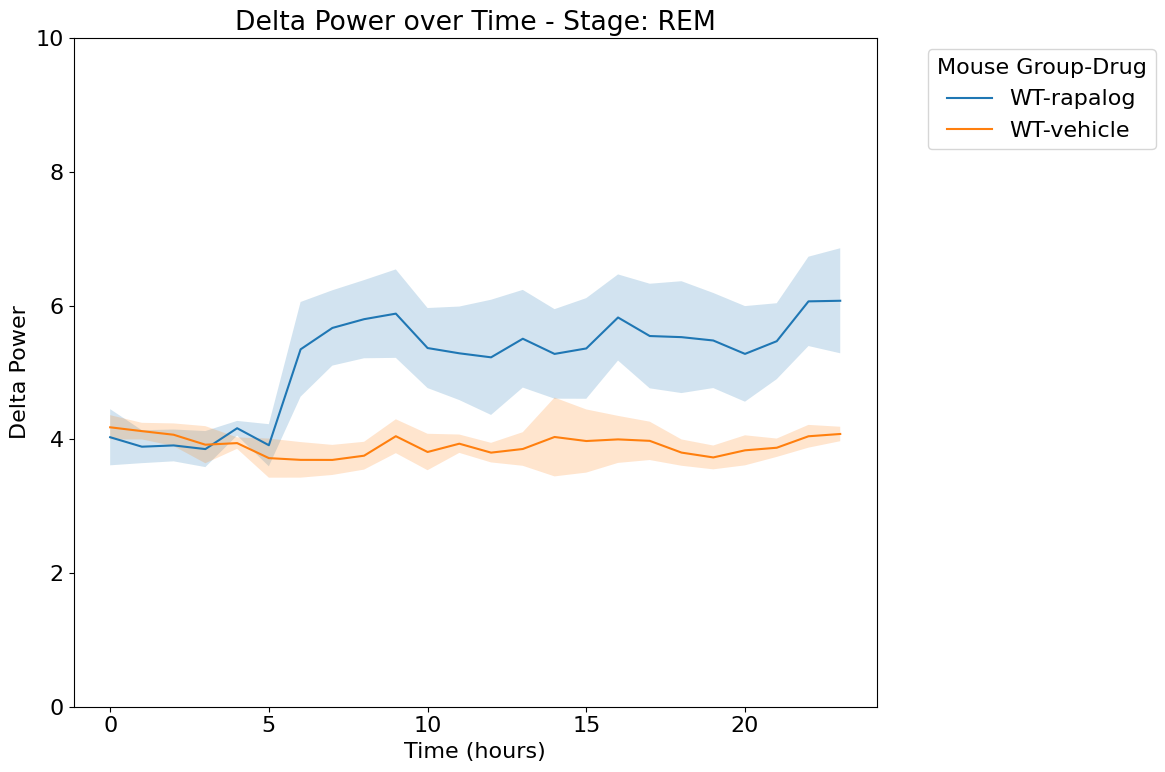

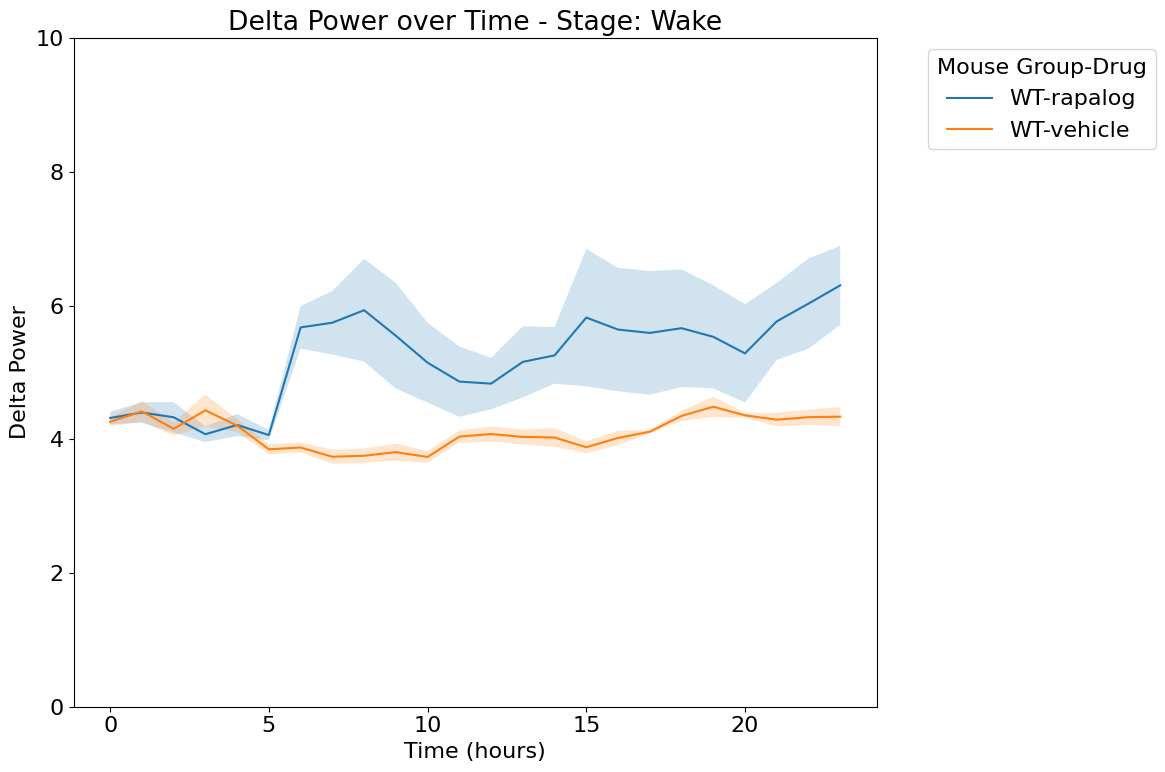

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-CZP/merge_psd_ts_df.csv')

# Group by mouse_group, drug, and time_in_hour, then calculate mean and standard error of delta_power
data_summary = data.groupby(['mouse_group', 'drug', 'time_in_hour', 'stage'])['delta_power']\
    .agg(mean='mean', sem='sem').reset_index()

# Plotting
stages = data_summary['stage'].unique()

for stage in stages:
    stage_data = data_summary[data_summary['stage'] == stage]
    plt.figure(figsize=(12, 8))

    for (mouse_group, drug), group_data in stage_data.groupby(['mouse_group', 'drug']):
        x = group_data['time_in_hour']
        y = group_data['mean']
        yerr = group_data['sem']

        plt.plot(x, y, label=f'{mouse_group}-{drug}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    # Customizing the plot
    plt.xlabel('Time (hours)')
    plt.ylabel('Delta Power')
    plt.title(f'Delta Power over Time - Stage: {stage}')
    plt.legend(title='Mouse Group-Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim([0,10])
    plt.tight_layout()

    # Show the plot
    plt.show()


In [11]:
a,b,c=group_analysis_each_df(meta_stage_df)

NameError: name 'meta_stage_df' is not defined

# effect of muric

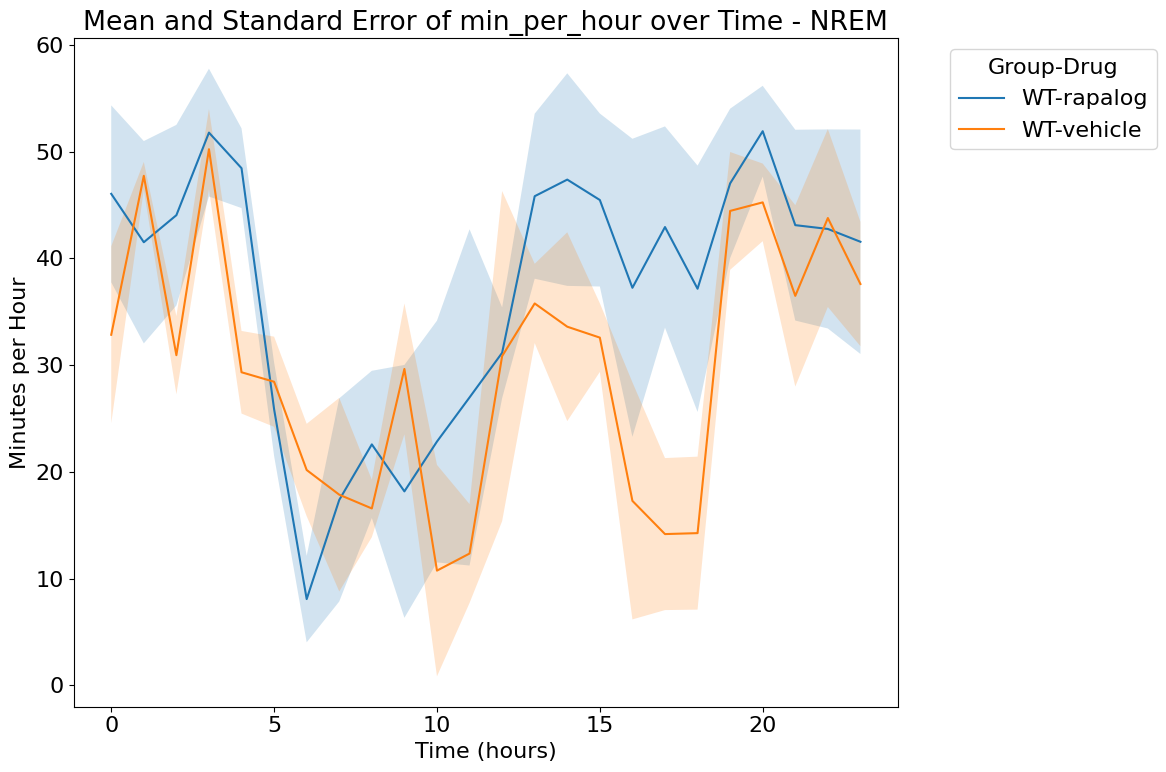

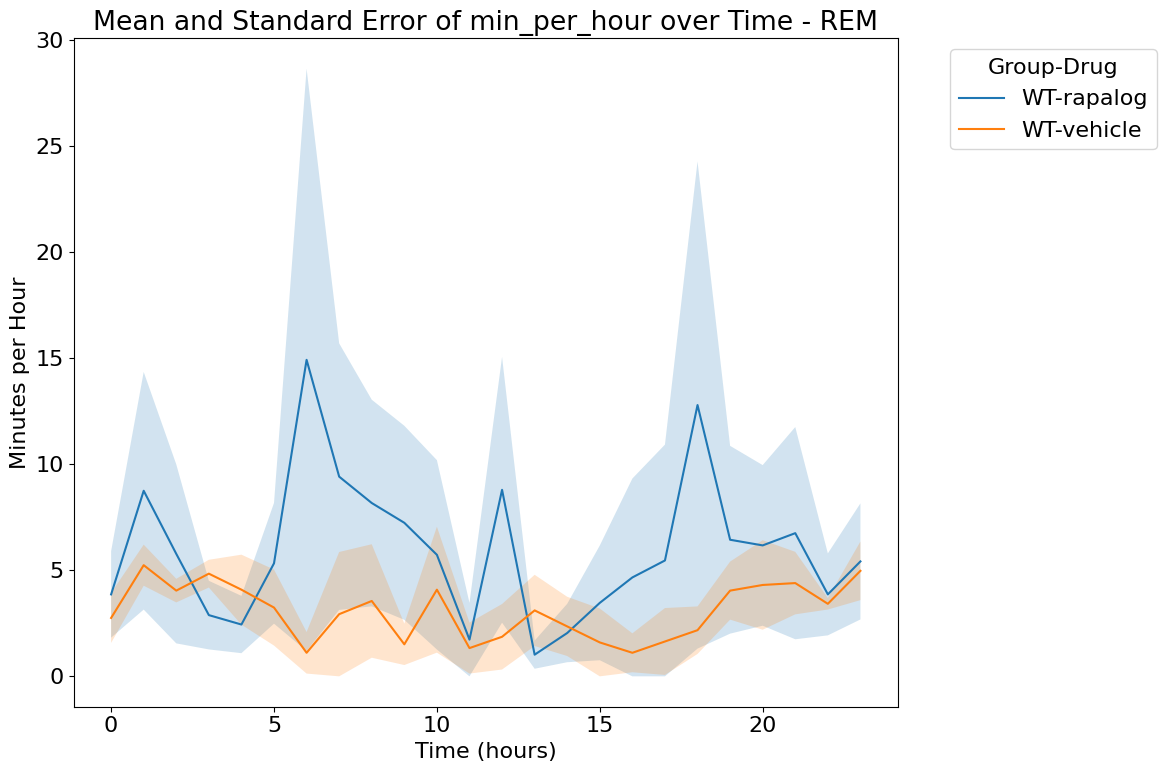

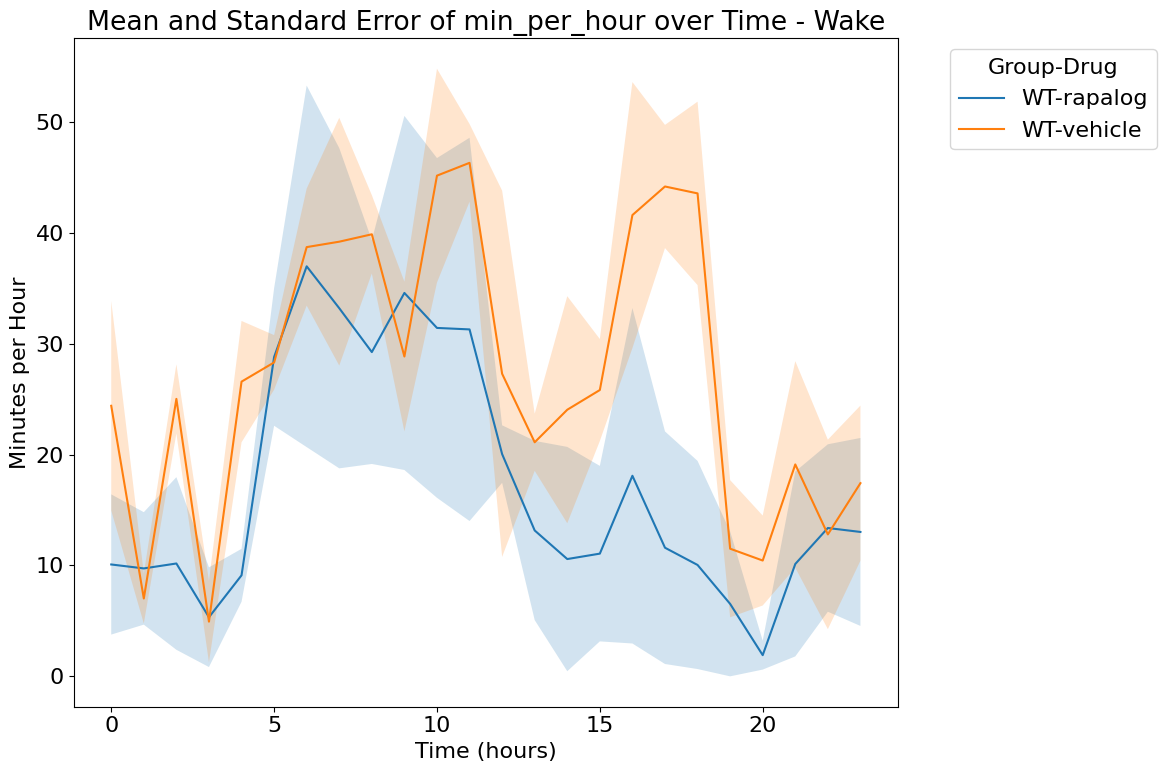

In [9]:
# Load the data
data = pd.read_csv('/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric/meta_stage_df.csv')
data=data[data.mouse_ID!="YI036"]
# Group by the relevant columns and calculate mean and standard error
summary = data.groupby(['mouse_group', 'stage', 'time_in_hour', 'drug'])['min_per_hour']\
    .agg(mean='mean', sem='sem').reset_index()

# Plotting
stages = summary['stage'].unique()

for stage in stages:
    stage_data = summary[summary['stage'] == stage]
    plt.figure(figsize=(12, 8))

    for (mouse_group, drug), group_data in stage_data.groupby(['mouse_group', 'drug']):
        x = group_data['time_in_hour']
        y = group_data['mean']
        yerr = group_data['sem']

        plt.plot(x, y, label=f'{mouse_group}-{drug}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    # Customizing the plot
    plt.xlabel('Time (hours)')
    plt.ylabel('Minutes per Hour')
    plt.title(f'Mean and Standard Error of min_per_hour over Time - {stage}')
    plt.legend(title='Group-Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()


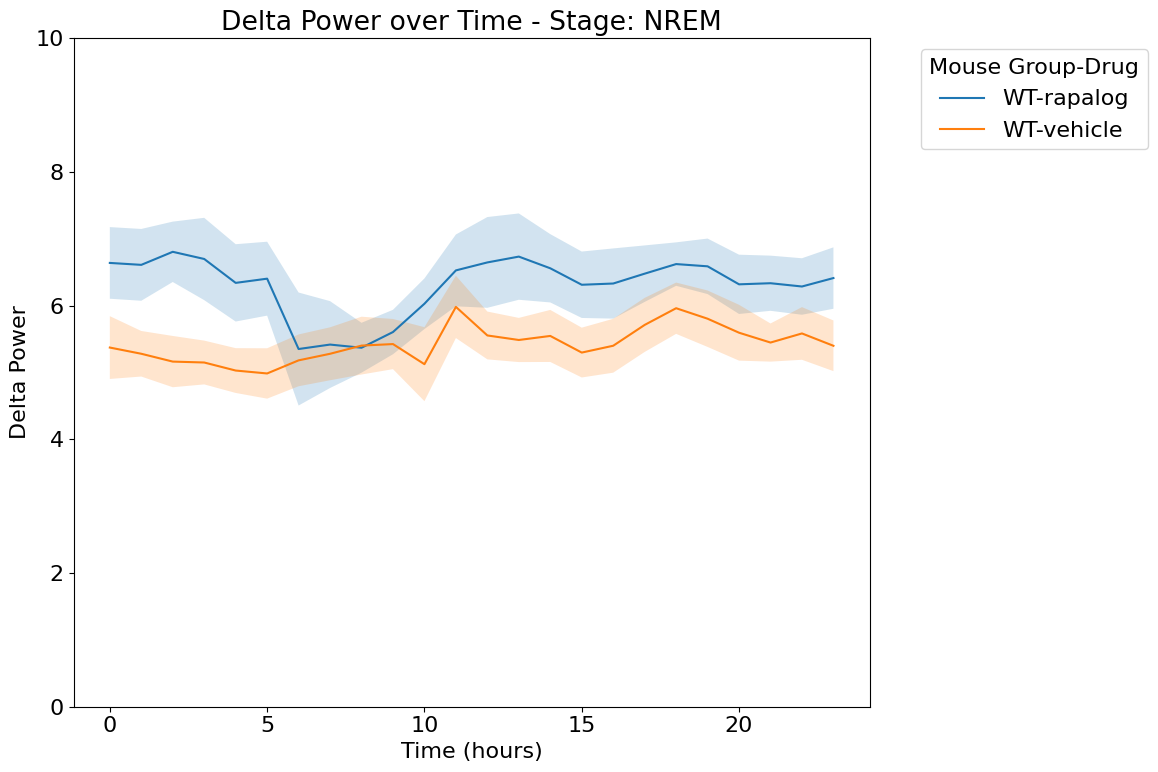

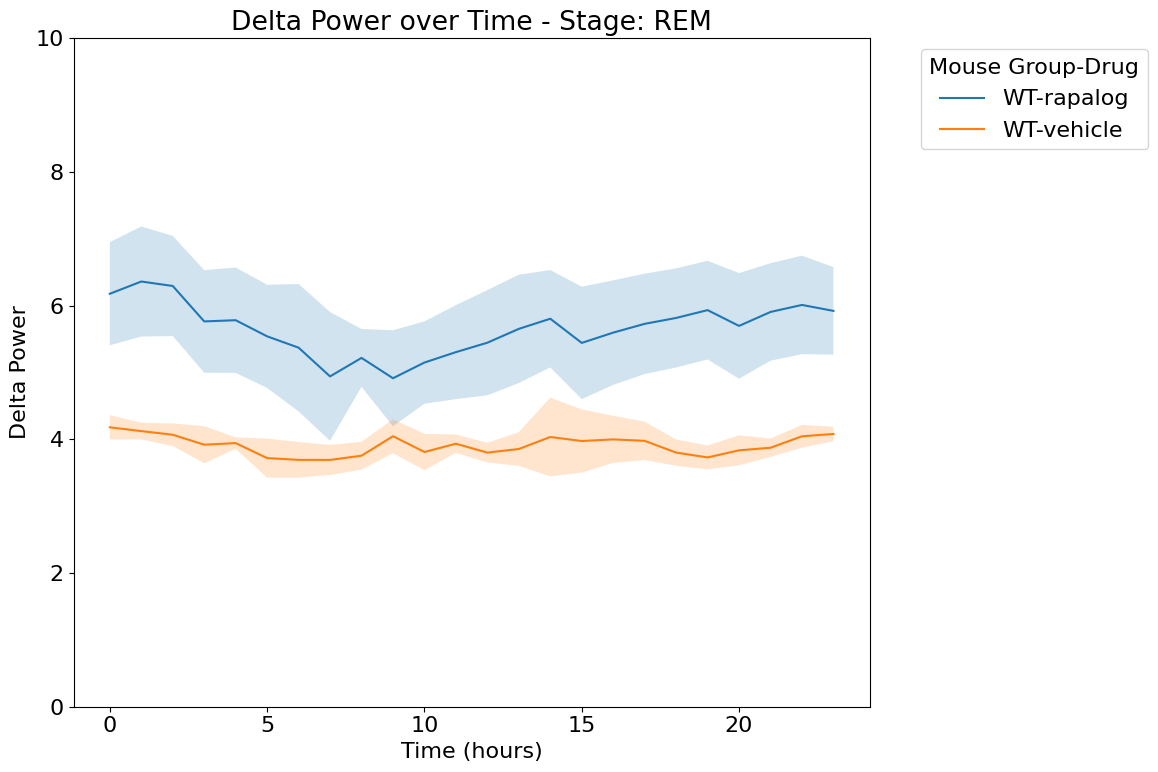

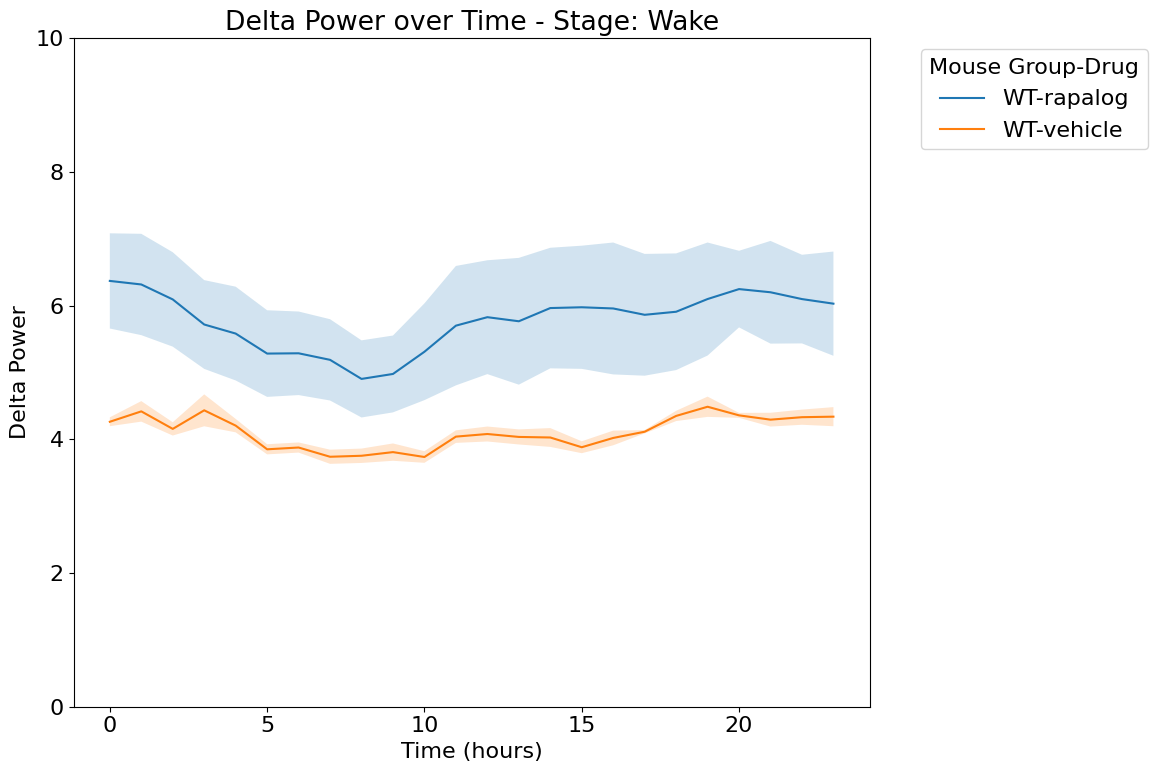

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('/p-antipsychotics-sleep/figure/prjCZP-9/effect-of-muric/merge_psd_ts_df.csv')
#data=data[data.mouse_ID!="YI036"]
# Group by mouse_group, drug, and time_in_hour, then calculate mean and standard error of delta_power
data_summary = data.groupby(['mouse_group', 'drug', 'time_in_hour', 'stage'])['delta_power']\
    .agg(mean='mean', sem='sem').reset_index()

# Plotting
stages = data_summary['stage'].unique()

for stage in stages:
    stage_data = data_summary[data_summary['stage'] == stage]
    plt.figure(figsize=(12, 8))

    for (mouse_group, drug), group_data in stage_data.groupby(['mouse_group', 'drug']):
        x = group_data['time_in_hour']
        y = group_data['mean']
        yerr = group_data['sem']

        plt.plot(x, y, label=f'{mouse_group}-{drug}')
        plt.fill_between(x, y - yerr, y + yerr, alpha=0.2)

    # Customizing the plot
    plt.xlabel('Time (hours)')
    plt.ylabel('Delta Power')
    plt.title(f'Delta Power over Time - Stage: {stage}')
    plt.legend(title='Mouse Group-Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.ylim([0,10])

    # Show the plot
    plt.show()


In [14]:
meta_stage_df

,exp_label,mouse_group,mouse_ID,stage,min_per_hour,time_in_hour,drug
0,EEG_p-iino-1-1,WT,YI033,REM,3.866667,0,vehicle
1,EEG_p-iino-1-1,WT,YI033,REM,6.800000,1,vehicle
2,EEG_p-iino-1-1,WT,YI033,REM,4.666667,2,vehicle
3,EEG_p-iino-1-1,WT,YI033,REM,4.800000,3,vehicle
4,EEG_p-iino-1-1,WT,YI033,REM,5.466667,4,vehicle
...,...,...,...,...,...,...,...
571,EEG_p-iino-1-1,WT,YI036,Wake,12.666667,19,rapalog
572,EEG_p-iino-1-1,WT,YI036,Wake,10.133333,20,rapalog
573,EEG_p-iino-1-1,WT,YI036,Wake,23.733333,21,rapalog
574,EEG_p-iino-1-1,WT,YI036,Wake,3.200000,22,rapalog


In [15]:
def aggregate_for_plotting(df, value_column):
    """
    Aggregate data for plotting mean and standard error by group, drug, and time_in_hour.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        value_column (str): Name of the column to aggregate (e.g., "min_per_hour").

    Returns:
        pd.DataFrame: Aggregated DataFrame with mean and SEM.
    """
    # 必要なカラムが存在するか確認
    required_columns = ["mouse_group", "drug","stage", "time_in_hour", value_column]
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in the DataFrame. Available columns: {df.columns.tolist()}")

    # グループ化と集計
    grouped = df.groupby(["mouse_group", "drug", "stage","time_in_hour"])[value_column]
    aggregated = grouped.agg(["mean", "sem"]).reset_index()

    # 列名のリネーム
    aggregated.rename(columns={"mean": f"{value_column}_mean", "sem": f"{value_column}_sem"}, inplace=True)

    # デバッグ情報
    print(f"Aggregated DataFrame:\n{aggregated.head()}")

    return aggregated


In [16]:
aggregated=aggregate_for_plotting(meta_stage_df,"min_per_hour")

Aggregated DataFrame:
  mouse_group     drug stage  time_in_hour  min_per_hour_mean  \
0          WT  rapalog  NREM             0          40.366667   
1          WT  rapalog  NREM             1          41.066667   
2          WT  rapalog  NREM             2          37.833333   
3          WT  rapalog  NREM             3          39.600000   
4          WT  rapalog  NREM             4          38.666667   

   min_per_hour_sem  
0          4.471929  
1          6.207045  
2          6.588289  
3          3.043877  
4          0.949074  


In [17]:
aggregated

,mouse_group,drug,stage,time_in_hour,min_per_hour_mean,min_per_hour_sem
0,WT,rapalog,NREM,0,40.366667,4.471929
1,WT,rapalog,NREM,1,41.066667,6.207045
2,WT,rapalog,NREM,2,37.833333,6.588289
3,WT,rapalog,NREM,3,39.600000,3.043877
4,WT,rapalog,NREM,4,38.666667,0.949074
...,...,...,...,...,...,...
139,WT,vehicle,Wake,19,12.800000,4.559727
140,WT,vehicle,Wake,20,11.333333,3.002715
141,WT,vehicle,Wake,21,22.133333,7.246966
142,WT,vehicle,Wake,22,13.233333,6.057105


In [15]:
y,err=extract_mean_n_err(a,b,"WT","vehicle","NREM","min_per_hour")

Extracting mean and err for group: WT, drug: vehicle, stage: NREM, value: min_per_hour
DataFrame columns: Index(['mouse_group', 'drug', 'stage', 'min_per_hour', 'time_in_hour'], dtype='object')
Filtered subset_mean shape: (1, 5), subset_sem shape: (1, 5)
Extracted y shape: (1,), err shape: (1,)


In [18]:
y

array([29.06805556])

In [19]:
test3=test.reset_index(drop=True)

In [15]:
test3

,exp_label,mouse_group,mouse_ID,Device label,stage,epoch #,time_in_hour,f@0.0,f@0.39143730886850153,f@0.7828746177370031,...,f@47.75535168195719,f@48.14678899082569,f@48.53822629969419,f@48.92966360856269,f@49.321100917431195,f@49.71253822629969,f@50.103975535168196,delta_power,theta_power,drug
0,EEG_p-iino-1-1,WT,YI033,Ch0,NREM,321,0,0.205784,0.724794,1.708488,...,0.000200,0.000186,0.000172,0.000159,0.000147,0.000152,0.000152,4.969058,2.531525,vehicle
1,EEG_p-iino-1-1,WT,YI033,Ch0,NREM,208,0,0.228605,0.789053,1.868880,...,0.000179,0.000159,0.000148,0.000140,0.000131,0.000136,0.000134,5.029675,2.482488,rapalog
2,EEG_p-iino-1-1,WT,YI033,Ch0,NREM,371,1,0.207495,0.767009,1.752045,...,0.000205,0.000196,0.000186,0.000170,0.000151,0.000149,0.000146,4.876493,2.555400,vehicle
3,EEG_p-iino-1-1,WT,YI033,Ch0,NREM,338,1,0.232433,0.832696,1.954994,...,0.000199,0.000184,0.000166,0.000154,0.000146,0.000146,0.000142,4.946909,2.504302,rapalog
4,EEG_p-iino-1-1,WT,YI033,Ch0,NREM,193,2,0.195618,0.694062,1.675064,...,0.000223,0.000199,0.000183,0.000175,0.000174,0.000171,0.000164,4.573067,2.659653,vehicle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,EEG_p-iino-1-1,WT,YI036,Ch3,Wake,178,21,0.205134,0.716003,1.528529,...,0.000343,0.000301,0.000278,0.000262,0.000245,0.000232,0.000215,6.235285,2.125600,rapalog
572,EEG_p-iino-1-1,WT,YI036,Ch3,Wake,109,22,0.233852,1.003472,1.810760,...,0.000448,0.000418,0.000385,0.000357,0.000325,0.000287,0.000255,4.230430,2.811774,vehicle
573,EEG_p-iino-1-1,WT,YI036,Ch3,Wake,24,22,0.229768,0.733444,1.733834,...,0.000523,0.000515,0.000468,0.000433,0.000400,0.000347,0.000318,6.018002,2.166850,rapalog
574,EEG_p-iino-1-1,WT,YI036,Ch3,Wake,272,23,0.317560,1.353248,2.321988,...,0.000681,0.000628,0.000586,0.000547,0.000512,0.000473,0.000434,4.116734,2.796359,vehicle


In [18]:
def calculate_ratio_with_groupby_fixed(
    df, 
    baseline_start, 
    baseline_end,
    final_index_names=None
):
    """
    1) level_6 -> 'time_in_hour' に強制リネーム
    2) reset_index() でカラム化
    3) time_in_hour が 40倍なら補正
    4) ベースライン計算＆比率計算
    5) 最後にインデックス名を元に戻す (final_index_namesを渡す)
    """
    print("[DEBUG] Before rename, df.index.names:", df.index.names)
    
    # --- 1) level_6 -> 'time_in_hour'
    # もし len(df.index.names) > 6 の状況なら、6番目を強制リネーム
    # ただし実際に level_6 が存在するか要確認
    if len(df.index.names) > 6:
        df.index = df.index.set_names("time_in_hour", level=6)
        print("[DEBUG] Renamed level_6 -> 'time_in_hour'. Now df.index.names:", df.index.names)
    else:
        print("[WARN] level_6 does not exist or index structure is unexpected.")
    
    # --- 2) reset_index()でカラム化
    df_reset = df.reset_index()
    print("[DEBUG] After reset_index, columns:", df_reset.columns)

    # time_in_hour が存在しないなら処理できないのでチェック
    if "time_in_hour" not in df_reset.columns:
        print("[ERROR] 'time_in_hour' not found after reset_index. Aborting.")
        return df_reset  # または raise

    # --- 3) time_in_hour が 40倍か補正
    max_val = df_reset["time_in_hour"].max()
    print("[DEBUG] time_in_hour max before scale fix:", max_val)
    if max_val > 24:
        print("[DEBUG] Detected time_in_hour scaled by factor ~40. Dividing by 40.")
        df_reset["time_in_hour"] = df_reset["time_in_hour"] // 40
    print("[DEBUG] Unique time_in_hour after fix:", df_reset["time_in_hour"].unique())

    # 数値カラム
    numeric_cols = df_reset.select_dtypes(include="number").columns.tolist()
    print("[DEBUG] numeric_cols:", numeric_cols)

    # ベースライン用フィルタリング
    baseline_df = df_reset[
        (df_reset["time_in_hour"] >= baseline_start) & (df_reset["time_in_hour"] <= baseline_end)
    ]
    print("[DEBUG] baseline_df:\n", baseline_df.head())

    # ここでは仮に group_keys を numeric_cols + time_in_hour 以外にする (例)
    group_keys = [c for c in df_reset.columns if c not in numeric_cols + ["time_in_hour"]]
    print("[DEBUG] group_keys:", group_keys)

    # ベースライン平均
    baseline_means = (
        baseline_df.groupby(group_keys)[numeric_cols].mean().reset_index()
    )
    print("[DEBUG] baseline_means:\n", baseline_means.head())

    # マージ
    merged_df = df_reset.merge(baseline_means, on=group_keys, how="left", suffixes=("", "_base"))
    # 比率計算
    for col in numeric_cols:
        base_col = f"{col}_base"
        if base_col in merged_df.columns:
            merged_df[col] = (merged_df[col] / merged_df[base_col]) * 100
    
    # 不要カラム削除
    base_cols = [f"{col}_base" for col in numeric_cols if f"{col}_base" in merged_df.columns]
    merged_df.drop(columns=base_cols, inplace=True, errors="ignore")
    print("[DEBUG] merged_df after ratio calc:\n", merged_df.head())

    # --- 5) 最後にインデックス名を元に戻す (ユーザー指定の final_index_names を想定)
    if final_index_names is not None and len(final_index_names) == len(df.index.names):
        # final_index_names に含まれるカラムが merged_df に存在している場合のみセット
        valid_idx_cols = [c for c in final_index_names if c in merged_df.columns]
        if len(valid_idx_cols) == len(final_index_names):
            merged_df.set_index(valid_idx_cols, inplace=True)
            merged_df.index.names = final_index_names
            print("[DEBUG] Restored index names:", merged_df.index.names)
        else:
            print("[WARN] Some final_index_names are not in merged_df columns. Skipping index restore.")
    else:
        print("[WARN] final_index_names not provided or length mismatch. Skipping index restore.")
    
    return merged_df


In [19]:
test2=calculate_ratio_with_groupby_fixed(test, 0, 5)

NameError: name 'test' is not defined

In [ ]:
test2

In [ ]:
test